### Guidance
This script will
- plot O3 vs NOx
- plot O3 vs OH reactivity

In [1]:
# ==============
# Import modules
# ==============
import warnings
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
import pandas as pd
import scipy.io
import os
import seaborn as sns
from matplotlib.colors import ListedColormap
import re
from pathlib import Path

# Changing the CWD
os.chdir('/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_helper')
from F0AM_reader_MASTER import *
from data_processing import *
from Flight_transect_csv_reader import *
from VOCR_reader_cases import *
from Plotting_helper import *

warnings.filterwarnings('ignore')

In [2]:
# Setting for smk or bkg
get_smk      = False
get_smk_dil  = True
get_smk_norm = False
get_nemr     = False # always make it false, maybe clean it up in the future

# Setting up postfic name
if get_smk:      postfix = 'smk'
if get_smk_dil:  postfix = 'smk_dil'

# Using VOCs to calculate photochemical age
voc_names = ['Furan', 'Furfural', 'Furanone', 'Butadiene', 
             'Phenol', 'Tolualdehyde', 'Benzene', 'Guaiacol', 
             'Isoprene', 'Ethanol', 'Styrene']
voc_names = ['Furan', 'Furfural', 'Furanone',
             'Butadiene', 'Guaiacol']

In [16]:
df_x_obs['Observation']

Avg_physical_age_min
0.02     174.311557
2.25     170.244014
7.03     208.784337
11.86    236.068970
16.66    298.948174
21.30    305.587239
26.04    323.974862
30.64    366.204782
35.32    465.228892
40.18    408.174916
44.79    476.866114
49.38    474.240968
54.14    464.776149
58.84    596.119872
61.21    742.287967
Name: Observation, dtype: float64

#### Ozone vs POx vs NOx vs VOCR vs Chemical age

#### One figure

RF03
RF07
RF09
FN19
P-3B


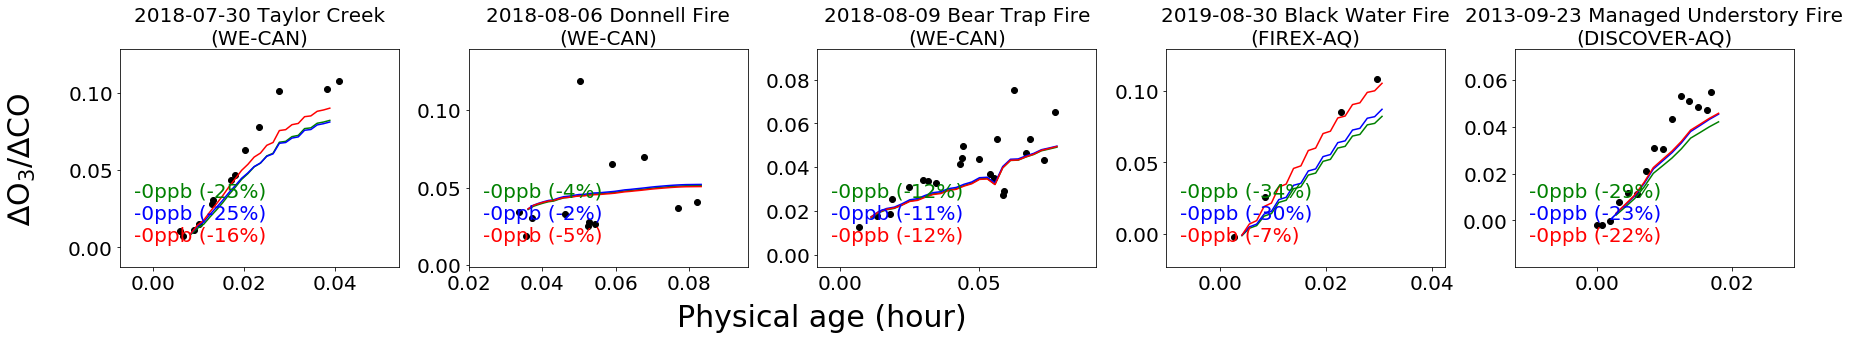

In [19]:
# Read compounds and each flight dataframe
Flight_IDs   = ['RF03', 'RF07', 'RF09', 'FN19', 'P-3B']
#Flight_IDs   = ['P-3B', 'RF03', 'FN19', 'RF07', 'RF09']
Flight_IDs   = ['RF03', 'RF07', 'RF09']
#Flight_IDs   = ['RF07', 'RF07']
Flight_IDs   = ['RF03', 'RF07', 'RF09', 'FN19', 'P-3B']

# TVOCR
#target_y, target_x, postfix, chem_age = 'TVOCR', 'Physical age', 'smk_dil', 1

# NOx
#target_y, target_x, postfix, chem_age = 'NOx', 'Physical age', 'smk_dil', 1



# OH concentration
#target_y, target_x, postfix, chem_age = 'OH concentration', 'Physical age', 'smk_dil', 0

# Ozone NEMR vs OHRvoc: OHRnox fateio
#target_y, target_x, postfix, chem_age = 'NEMR(O3)', 'OHRvoc vs OHRnox', 'smk_dil', 0


# Ozone NEMR
target_y, target_x, postfix, chem_age = 'NEMR(O3)', 'Chemical age', 'smk_dil', 0
target_y, target_x, postfix, chem_age = 'NEMR(O3)', 'Physical age', 'smk_dil', 0

# OHRnox vs OHRvoc
#target_y, target_x, postfix, chem_age = 'OHRnox vs OHRvoc', 'Physical age', 'smk', 0

# LROx: LNOx
#target_y, target_x, postfix, chem_age = 'LROx vs LNOx_broad', 'Physical age', 'smk', 0

# Ln vs Q
#target_y, target_x, postfix, chem_age = 'Ln vs Q', 'Physical age', 'smk', 0

# POx and OHRnox vs OHRvoc
#target_y, target_x, postfix, chem_age = 'NEMR(O3)', 'OHRvoc vs OHRnox', 'smk', 0

#target_y, target_x, postfix, chem_age = 'CH2O', 'TVOCR', 'smk_dil', 0

#target_y, target_x, postfix, chem_age = 'NEMR(O3)', 'NOx', 'smk_dil', 0

#target_y, target_x, postfix, chem_age = 'PO3', 'NO', 'smk_dil', 0


# select the dilution corrected or not.

# plotting for the figure
linewidth = 3
shaded_uncertainty = 0.15
error_infor = False
fontsize_flight = 20
fontsize_tick   = 20
fontsize_lable  = 12
fontsize_comp   = 18
n_col, n_rol = 1, len(Flight_IDs)


# colors for model
colors = ['green', 'orange', \
          'red', 'blue']

# subplots 
fig, axes = plt.subplots(n_col, n_rol, 
                         figsize=(6*len(Flight_IDs), 4*n_col))
                         #sharex='col')
for col, Flight_ID in enumerate(Flight_IDs):
    print(Flight_ID)
    # Set up the starting point
    # File directory, auto change for each flight ID
    if Flight_ID in ['RF03', 'RF07', 'RF09']:file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Dataprocess/analysis_bycompound/'
    if Flight_ID in ['FN19']: file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/FIREX-AQ/Dataprocess/analysis_bycompound/'
    if Flight_ID in ['P-3B']: file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/P-3B/Dataprocess/analysis_bycompound/'
    file_prefix_PL  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/PL_budget/output/'

    # --------------
    # Reading data
    # Set up x and y
    # --------------
    # ! Initial CO
    # Read CO smk data
    data_CO_smk_init = pd.read_csv(f'{file_prefix_conc}CO/{Flight_ID}_obs_smk.csv', index_col=0)['Observation'].iloc[0]
    # !! Observation
    df_obs_nemr_o3 = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init
    df_obs_nemr_ox = (pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_obs_smk_dil.csv', index_col=0)+pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_obs_smk_dil.csv', index_col=0)) / data_CO_smk_init
    df_obs_o3      = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_no      = pd.read_csv(f'{file_prefix_conc}NO/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_no2     = pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_nox     = pd.read_csv(f'{file_prefix_conc}NOx/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_pan     = pd.read_csv(f'{file_prefix_conc}PAN/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_ch2o    = pd.read_csv(f'{file_prefix_conc}Formaldehyde/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_obs_ch2o_no2=df_obs_ch2o.div(df_obs_no2)

    if target_y in ['TVOCR', 'OHRvoc vs OHRnox', 'OHRnox vs OHRvoc'] or target_x in ['TVOCR', 'OHRvoc vs OHRnox', 'OHRnox vs OHRvoc']:
        df_obs_vocr = VOCR_reader_cases(Flight_ID=Flight_ID, get_smk_dil=(postfix == 'smk_dil'), get_smk_conc=(postfix == 'smk'))
        df_obs_OHRnox        = (df_obs_no*9.7605E-12 + df_obs_no2*9.8258E-12)*2.46e10
        df_obs_OHRvoc_OHRnox = df_obs_vocr.div(df_obs_OHRnox)
        df_obs_OHRnox_OHRvoc = df_obs_OHRnox.div(df_obs_vocr)
    else: # speed up the code
        df_obs_vocr = [np.nan]*len(df_obs_o3)
        df_obs_OHRnox = [np.nan]*len(df_obs_o3)
        df_obs_OHRvoc_OHRnox = [np.nan]*len(df_obs_o3)
        df_obs_OHRnox_OHRvoc = [np.nan]*len(df_obs_o3)
    # !! Model
    df_mod_nemr_o3 = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
    df_mod_nemr_ox = (pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0) +  pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_mod_smk_dil.csv', index_col=0))/ data_CO_smk_init
    df_mod_o3      = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_mod_no      = pd.read_csv(f'{file_prefix_conc}NO/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_mod_no2     = pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_mod_nox     = pd.read_csv(f'{file_prefix_conc}NOx/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_mod_pan     = pd.read_csv(f'{file_prefix_conc}PAN/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_mod_ch2o    = pd.read_csv(f'{file_prefix_conc}Formaldehyde/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_mod_vocr    = pd.read_csv(f'{file_prefix_conc}TVOCR/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_mod_vocr.index = df_mod_no.index
    df_mod_OHRnox  = (df_mod_no*9.7605E-12 + df_mod_no2*9.8258E-12)*2.46e10
    df_mod_OHRvoc_OHRnox = df_mod_vocr.div(df_mod_OHRnox) 

    df_mod_OHRnox_OHRvoc = df_mod_OHRnox.div(df_mod_vocr) 
    df_mod_ho2 = pd.read_csv(f'{file_prefix_conc}HO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_mod_ro2 = pd.read_csv(f'{file_prefix_conc}TRO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    # !! Model results
    # L(ROx)/L(NOx_broad)
    df_mod_nox_broad_loss = pd.read_csv(f'{file_prefix_PL}NOx_broad/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)
    df_mod_rox_loss       = pd.read_csv(f'{file_prefix_PL}ROx/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)   
    df_mod_Lrox_Lnox_broad= df_mod_rox_loss.div(df_mod_nox_broad_loss)
    # Ln/Q
    df_mod_hno3_prod = pd.read_csv(f'{file_prefix_PL}HNO3/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
    df_mod_hno4_prod = pd.read_csv(f'{file_prefix_PL}HNO4/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
    df_mod_pns_prod  = pd.read_csv(f'{file_prefix_PL}PNs/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
    df_mod_ans_prod  = pd.read_csv(f'{file_prefix_PL}ANs/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
    df_mod_Ln = -(df_mod_hno3_prod + df_mod_hno4_prod + df_mod_pns_prod + df_mod_ans_prod)
    #df_mod_Ln = pd.read_csv(f'{file_prefix_PL}NOx/{Flight_ID}_Loss_rates.csv', index_col=0)   
    df_mod_Q  = df_mod_Ln + df_mod_rox_loss
    df_mod_Ln_Q  = df_mod_Ln.div(df_mod_Q)
    
    # OPE
    df_mod_o3_prod    = pd.read_csv(f'{file_prefix_PL}O3/{Flight_ID}_Production_rates_evolution.csv', index_col=0)
    df_mod_ox_prod    = pd.read_csv(f'{file_prefix_PL}Ox/{Flight_ID}_Production_rates_evolution.csv', index_col=0)
    df_mod_ox_loss    = pd.read_csv(f'{file_prefix_PL}Ox/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)
    df_mod_ox_netprod = df_mod_ox_prod + df_mod_ox_loss
    df_mod_nox_loss   = pd.read_csv(f'{file_prefix_PL}NOx/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)   

    # OH evaluation
    # observation and model for OH or chemical age
    df_obs_cal_OH, df_mod_cal_OH, df_mod_ = calculate_oh_chem_age_stats(voc_names, file_prefix_conc, Flight_ID, 0)    
    # make df_obs_cal_OH as a dataframe with observation...
    df_obs_cal_OH = pd.DataFrame(df_obs_cal_OH['Median']).rename(columns={'Median': 'Observation'})
    
    # Get chemical age
    df_obs_cal_chem_age, df_mod_cal_chem_age, df_mod_output_chem_age = calculate_oh_chem_age_stats(voc_names, file_prefix_conc, Flight_ID, 1)    
    # make df_obs_cal_OH as a dataframe with observation...
    df_obs_cal_chem_age = pd.DataFrame(df_obs_cal_chem_age['Median']).rename(columns={'Median': 'Observation'})
    
    # ---------------------------------
    # Data processing
    # filter out extremelly high data
    # e.g., intial ozone production
    # ---------------------------------
    #df_mod_o3_prod = filter_df_by_first_column_percentiles(df_mod_o3_prod, 0, 0.9)
    #df_mod_ox_prod = filter_df_by_first_column_percentiles(df_mod_ox_prod, 0, 0.9)
    #df_mod_ox_netprod = filter_df_by_first_column_percentiles(df_mod_ox_netprod, 0, 0.7)
    
    # ---------------------
    # Data processing
    # standardize, bin time
    # ---------------------
    standard_index = df_mod_o3_prod.index.values if target_y in ['PO3', 'POx', 'net POx', 'OPE', 'Ln', 'LROx', 'Ln vs Q', 'LROx vs LNOx_broad'] else df_mod_o3.index.values    
    # Concentration
    df_mod_o3_interp            = interp(df_mod_o3, standard_index)
    df_mod_nemr_o3_interp       = interp(df_mod_nemr_o3, standard_index)
    df_mod_nemr_ox_interp       = interp(df_mod_nemr_ox, standard_index)
    df_mod_no_interp            = interp(df_mod_no, standard_index)
    df_mod_no2_interp           = interp(df_mod_no2, standard_index)
    df_mod_nox_interp           = interp(df_mod_nox, standard_index)
    df_mod_pan_interp           = interp(df_mod_pan, standard_index)
    df_mod_ch2o_interp          = interp(df_mod_ch2o, standard_index)
    df_mod_vocr_interp          = interp(df_mod_vocr, standard_index)
    df_mod_OHRnox_interp        = interp(df_mod_OHRnox, standard_index)
    df_mod_OHRvoc_OHRnox_interp = interp(df_mod_OHRvoc_OHRnox, standard_index)
    df_mod_OHRnox_OHRvoc_interp = interp(df_mod_OHRnox_OHRvoc, standard_index)
    df_mod_cal_OH_interp         = interp(df_mod_cal_OH, standard_index)
    #df_mod_output_OH_interp      = interp(df_mod_output_OH, standard_index)
    df_mod_cal_chem_age_interp   = interp(df_mod_cal_chem_age, standard_index)
    df_mod_output_chem_age_interp= interp(df_mod_output_chem_age, standard_index)
    
    df_mod_ho2_interp           = interp(df_mod_ho2, standard_index)
    df_mod_ro2_interp           = interp(df_mod_ro2, standard_index)
    # L(ROx)/L(NOx_broad)
    df_mod_nox_broad_loss_interp = interp(df_mod_nox_broad_loss, standard_index)
    df_mod_rox_loss_interp       = interp(df_mod_rox_loss, standard_index)
    df_mod_Lrox_Lnox_broad_interp= interp(df_mod_Lrox_Lnox_broad, standard_index)
    # Ln/Q
    df_mod_Ln_interp             = interp(df_mod_Ln, standard_index)
    df_mod_Q_interp              = interp(df_mod_Q, standard_index)
    df_mod_Ln_Q_interp           = interp(df_mod_Ln_Q, standard_index)
    
    # OPE
    df_mod_o3_prod_interp        = interp(df_mod_o3_prod, standard_index)
    df_mod_ox_prod_interp        = interp(df_mod_ox_prod, standard_index)
    df_mod_ox_netprod_interp     = interp(df_mod_ox_netprod, standard_index)
    df_mod_nox_loss_interp       = interp(df_mod_nox_loss, standard_index)
    
    # ------------
    # Bin the data
    # ------------
    if 'RF' not in Flight_ID: interval = 5
    if Flight_ID == 'RF03': interval = 5
    if Flight_ID == 'RF07': interval = 5
    if Flight_ID == 'RF09': interval = 10
    df_mod_o3_bin     = bin_df(df_mod_o3_interp,interval).iloc[1:]
    df_mod_nemr_o3_bin= bin_df(df_mod_nemr_o3_interp,interval).iloc[1:]
    df_mod_nemr_ox_bin= bin_df(df_mod_nemr_ox_interp,interval).iloc[1:]
    df_mod_no_bin     = bin_df(df_mod_no_interp,interval).iloc[1:]
    df_mod_no2_bin    = bin_df(df_mod_no2_interp,interval).iloc[1:]
    df_mod_nox_bin    = bin_df(df_mod_nox_interp,interval).iloc[1:]
    df_mod_pan_bin    = bin_df(df_mod_pan_interp,interval).iloc[1:]
    df_mod_ch2o_bin   = bin_df(df_mod_ch2o_interp,interval).iloc[1:]
    df_mod_vocr_bin   = bin_df(df_mod_vocr_interp,interval).iloc[1:]
    df_mod_OHRnox_bin = bin_df(df_mod_OHRnox_interp,interval).iloc[1:]
    df_mod_OHRvoc_OHRnox_bin = bin_df(df_mod_OHRvoc_OHRnox_interp,interval).iloc[1:]
    df_mod_OHRnox_OHRvoc_bin = bin_df(df_mod_OHRnox_OHRvoc_interp,interval).iloc[1:]
    #df_mod_output_OH_bin      = bin_df(df_mod_output_OH_interp, interval).iloc[1:]
    df_mod_output_chem_age_bin= bin_df(df_mod_output_chem_age_interp, interval).iloc[1:]
    df_mod_ho2_bin      = bin_df(df_mod_ho2_interp, interval).iloc[1:]
    df_mod_ro2_bin      = bin_df(df_mod_ro2_interp, interval).iloc[1:]
    
    # Special implementation for calculated OH/chemical age. The VOCs selected in this case is not in the CTMs thus we have to assume all experients shared the same calculated values
    # Make the Chemical age bin the same pattern as other simulations
    df_mod_cal_OH_bin_dummy  = bin_df(df_mod_cal_OH_interp, interval).iloc[1:] # this is only application for MCMBBVOC
    df_mod_cal_chem_age_bin_dummy  = bin_df(df_mod_cal_chem_age_interp, interval).iloc[1:] # this is only application for MCMBBVOC
    dummy_cols = ['GEOS-Chem (base)', 'GEOS-Chem + FUR', 'MCM + FUR', 'MCM + GEOS-Chem VOCs']
    # Create a new DataFrame with repeated median and IQR values across specified columns
    df_mod_cal_chem_age_bin = pd.DataFrame(index=df_mod_cal_chem_age_bin_dummy.index, columns=pd.MultiIndex.from_product([dummy_cols, ['median', 'iqr']]))
    df_mod_cal_OH_bin = pd.DataFrame(index=df_mod_cal_OH_bin_dummy.index, columns=pd.MultiIndex.from_product([dummy_cols, ['median', 'iqr']]))
    for column in dummy_cols:
        df_mod_cal_chem_age_bin[(column, 'median')], df_mod_cal_chem_age_bin[(column, 'iqr')] = df_mod_cal_chem_age_bin_dummy['Median', 'median'], df_mod_cal_chem_age_bin_dummy['Median', 'iqr']
        df_mod_cal_OH_bin[(column, 'median')], df_mod_cal_OH_bin[(column, 'iqr')] = df_mod_cal_OH_bin_dummy['Median', 'median'], df_mod_cal_OH_bin_dummy['Median', 'iqr']
    
    # L(ROx)/L(NOx_broad)
    df_mod_nox_broad_loss_bin = bin_df(df_mod_nox_broad_loss, interval).iloc[1:]
    df_mod_rox_loss_bin       = bin_df(df_mod_rox_loss, interval).iloc[1:]
    df_mod_Lrox_Lnox_broad_bin= bin_df(df_mod_Lrox_Lnox_broad, interval).iloc[1:]
    # Ln/Q
    df_mod_Ln_bin             = bin_df(df_mod_Ln, interval).iloc[1:]
    df_mod_Q_bin              = bin_df(df_mod_Q, interval).iloc[1:]
    df_mod_Ln_Q_bin           = bin_df(df_mod_Ln_Q, interval).iloc[1:]
    # OPE
    df_mod_o3_prod_bin        = bin_df(df_mod_o3_prod, interval).iloc[1:]
    df_mod_ox_prod_bin        = bin_df(df_mod_ox_prod, interval).iloc[1:]
    df_mod_ox_netprod_bin     = bin_df(df_mod_ox_netprod, interval).iloc[1:]
    df_mod_nox_loss_bin       = bin_df(df_mod_nox_loss, interval).iloc[1:]
    # --------------------
    # Select targt x and y
    # --------------------
    # Dictionary mapping targets to their corresponding dataframes
    dataframes_mapping = {
        'NO':              (df_obs_no, df_mod_no_bin),
        'NO2':             (df_obs_no2, df_mod_no2_bin),
        'NOx':             (df_obs_nox, df_mod_nox_bin),
        'PAN':             (df_obs_pan, df_mod_pan_bin),
        'CH2O':            (df_obs_ch2o, df_mod_ch2o_bin),
        'TVOCR':           (df_obs_vocr, df_mod_vocr_bin),
        'Ozone':           (df_obs_o3, df_mod_o3_bin),
        'NEMR(O3)':        (df_obs_nemr_o3, df_mod_nemr_o3_bin),
        'NEMR(Ox)':        (df_obs_nemr_ox, df_mod_nemr_ox_bin),
        'OHRnox':          (df_obs_OHRnox, df_mod_OHRnox_bin),
        'OHRvoc vs OHRnox':(df_obs_OHRvoc_OHRnox, df_mod_OHRvoc_OHRnox_bin),
        'OHRnox vs OHRvoc':(df_obs_OHRnox_OHRvoc, df_mod_OHRnox_OHRvoc_bin),
        'Physical age':    (df_obs_o3.assign(Observation=df_obs_o3.index)/60,
                            df_mod_o3_bin.apply(lambda col_test: df_mod_o3_bin.index if 'median' in col_test.name else 0, axis=0)/60),
        'Chemical age':    (df_obs_cal_chem_age, df_mod_cal_chem_age_bin), 
        #'OH analysis':     (df_obs_cal_OH, df_mod_output_OH_bin), # !!! This is specailly set and can be modified for own purpose!!!
        'LROx':            (df_obs_o3.applymap(lambda x: np.nan), df_mod_rox_loss_bin),
        'LNOx_broad':      (df_obs_o3.applymap(lambda x: np.nan), df_mod_nox_broad_loss_bin),
        'LROx vs LNOx_broad':(df_obs_o3.applymap(lambda x: np.nan), df_mod_Lrox_Lnox_broad_bin),
        'Ln':                (df_obs_o3.applymap(lambda x: np.nan), df_mod_Ln_bin),
        'Q':                 (df_obs_o3.applymap(lambda x: np.nan), df_mod_Q_bin),
        'Ln vs Q':           (df_obs_o3.applymap(lambda x: np.nan), df_mod_Ln_Q_bin),
        'PO3':               (df_obs_o3.applymap(lambda x: np.nan), df_mod_o3_prod_bin),
        'POx':               (df_obs_o3.applymap(lambda x: np.nan), df_mod_ox_prod_bin),
        'net POx':           (df_obs_o3.applymap(lambda x: np.nan), df_mod_ox_netprod_bin),
        'LNOx':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_nox_loss_bin),
    }

    # Select target x and y
    df_x_obs, df_x_mod = dataframes_mapping.get(target_x, (None, None))
    df_y_obs, df_y_mod = dataframes_mapping.get(target_y, (None, None))
    # Replace the 0 as nan in the observation data
    df_x_obs['Observation'] = df_x_obs['Observation'].replace(0, np.nan)
    df_y_obs['Observation'] = df_y_obs['Observation'].replace(0, np.nan)
    # --------
    # Plotting
    # --------
    ax = axes[col]
    # Observations
    if not ((df_x_obs['Observation'].eq(0)).all()) and \
        not (df_x_obs['Observation'].isna().all()) and \
        not ((df_x_obs['Observation'].eq(0)).all()) and \
        not (df_y_obs['Observation'].isna().all()):
        # Observational scatter plot
        ax.scatter(df_x_obs['Observation']/60, df_y_obs['Observation'], 
                          label = 'Obs', color = 'black')
        
        # Perform linear regression
        idx = np.isfinite(df_x_obs['Observation']) & np.isfinite(df_y_obs['Observation'])
        slope, intercept = np.polyfit(df_x_obs['Observation'][idx], df_y_obs['Observation'][idx], 1)

        # Calculate R-squared
        correlation_matrix = np.corrcoef(df_x_obs['Observation'][idx], df_y_obs['Observation'][idx])
        correlation_xy = correlation_matrix[0,1]
        r_squared = correlation_xy**2

        # Plot regression line
        x_vals = np.array(ax.get_xlim())
        y_vals = intercept + slope * x_vals
        #ax.plot(x_vals, y_vals, '--', color='gray')

        ## Annotate with slope and R-squared
        #aax.text(0.05, 0.95, f'Slope: {slope:.2f}\n$R^2$: {r_squared:.2f}', transform=ax.transAxes, 
        #               fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # Model results
    ax.plot([x/60 for x in df_x_mod['GEOS-Chem (base)', 'median'].tolist()], df_y_mod['GEOS-Chem (base)', 'median'],
                   color=colors[0], label='$GC$')#, marker='o')  # Line plot with markers
    ax.plot([x/60 for x in df_x_mod['MCM + GEOS-Chem VOCs', 'median'].tolist()], df_y_mod['MCM + GEOS-Chem VOCs', 'median'],
                   color=colors[3], label='$MCM_{GCVOC}$')#, marker='o')  # Line plot with markers
    ax.plot([x/60 for x in df_x_mod['MCM + FUR', 'median'].tolist()], df_y_mod['MCM + FUR', 'median'],
                   color=colors[2], label='$MCM_{BBVOC}$')#, marker='o')  # Line plot with marker
    
    # Add a horizontal line at y = 0.5 to the axes
    if (target_y, target_x) == ('LROx vs LNOx_broad', 'Physical age') : ax.axhline(y=1, color='black', linestyle='-')    
    if (target_y, target_x) == ('Ln vs Q', 'Physical age') : ax.axhline(y=0.5, color='black', linestyle='-')    

    # start from 0
    #ax.set_ylim(bottom=0)

    # ----------------------------------
    # Texts for slope and R square value
    # ---------------------------------
    # set up the row
    ax.set_title(id2fire_name[Flight_ID], loc ='center', size=fontsize_flight)

    ax.tick_params(axis='both', labelsize=fontsize_tick)

    # Format y-axis tick labels to two decimal places
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    #ax.yaxis.set_major_formatter(mticker.FormatStrFormatter())
    
    # Set x-axis ticks and labels with an interval of 0.5
    if target_x == 'Plume age':
        # Start with the default tick positions
        default_ticks = ax.get_xticks()
        # Create new tick positions with an interval of 0.5
        new_ticks = np.arange(default_ticks[0], default_ticks[-1] + 0.5, 0.5)
        if Flight_ID == 'P-3B': new_ticks = new_ticks[1:]
        if Flight_ID == 'RF07': new_ticks = new_ticks[1:-2]
        if Flight_ID == 'RF09': new_ticks = new_ticks[1:-2]
        ax.set_xticks(new_ticks)
        ax.set_xticklabels([f"{tick:.1f}" for tick in new_ticks], rotation=30)

    
    # -------------------------------------
    # Calculate the model: observation bias
    # -------------------------------------
    if not ((df_x_obs['Observation'].eq(0)).all()) and \
        not (df_x_obs['Observation'].isna().all()) and \
        not ((df_x_obs['Observation'].eq(0)).all()) and \
        not (df_y_obs['Observation'].isna().all()):
        # Polinomial regression line
        # train the model based on observation data
        idx = np.isfinite(df_x_obs['Observation']) & np.isfinite(df_y_obs['Observation'])         # only pass datapoint with values
        coefs = np.polyfit(df_x_obs['Observation'][idx], df_y_obs['Observation'][idx], 2) # 3 may be the best fit
        poly_model = np.poly1d(coefs)
        # text for observations
        relative_diff1 = (df_y_mod['GEOS-Chem (base)', 'median']-poly_model(df_x_mod['GEOS-Chem (base)', 'median']))/poly_model(df_x_mod['GEOS-Chem (base)', 'median']) * 100       
        relative_diff1 = relative_diff1
        abs_diff1 = df_y_mod['GEOS-Chem (base)', 'median']-poly_model(df_x_mod['GEOS-Chem (base)', 'median'])

        relative_diff3 = (df_y_mod['MCM + GEOS-Chem VOCs', 'median']-poly_model(df_x_mod['MCM + GEOS-Chem VOCs', 'median']))/poly_model(df_x_mod['MCM + GEOS-Chem VOCs', 'median']) * 100       
        relative_diff3 = relative_diff3
        abs_diff3 = df_y_mod['MCM + GEOS-Chem VOCs', 'median']-poly_model(df_x_mod['MCM + GEOS-Chem VOCs', 'median'])

        relative_diff4 = (df_y_mod['MCM + FUR', 'median']-poly_model(df_x_mod['MCM + FUR', 'median']))/poly_model(df_x_mod['MCM + FUR', 'median']) * 100   
        relative_diff4 = relative_diff4 
        abs_diff4 = df_y_mod['MCM + FUR', 'median']-poly_model(df_x_mod['MCM + FUR', 'median'])

        # median of the diff
        relative_diff1 = np.nanmedian(relative_diff1)
        relative_diff3 = np.nanmedian(relative_diff3)
        relative_diff4 = np.nanmedian(relative_diff4)
        abs_diff1 = np.nanmedian(abs_diff1)
        abs_diff3 = np.nanmedian(abs_diff3)
        abs_diff4 = np.nanmedian(abs_diff4)

        # last data point of the diff
        diff_str1   = '{:.0f}'.format(abs_diff1) + 'ppb (' + '{:.0f}'.format(relative_diff1) +'%)'
        diff_str3   = '{:.0f}'.format(abs_diff3) + 'ppb (' + '{:.0f}'.format(relative_diff3) +'%)'
        diff_str4   = '{:.0f}'.format(abs_diff4) + 'ppb (' + '{:.0f}'.format(relative_diff4) +'%)'
        
        # Texts
        # get the range for the x/y axis
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        if target_x in Comps_in_GC and target_y in Comps_in_GC:
            ax.text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.32+ymin, diff_str1, fontsize=fontsize_tick, color = colors[0])  
            ax.text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.22+ymin, diff_str3, fontsize=fontsize_tick, color = colors[3])  
        ax.text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.12+ymin, diff_str4, fontsize=fontsize_tick, color = colors[2])

        
# Spacing Out
plt.subplots_adjust(wspace=.25, hspace=.10)
            
# Texts
x_label = text_labels.get(target_x, target_x)  # Get the label from the dictionary, default to empty string if not found
if x_label: 
    if len(Flight_IDs)==5: fig.text(0.45,-0.05, x_label, ha="center", va="center", rotation=0, fontsize=30)
y_label = text_labels.get(target_y, target_y)  # Get the label from the dictionary, default to empty string if not found
if y_label: 
    if len(Flight_IDs)==3: fig.text(0.06,0.5, y_label, ha="center", va="center", rotation=90, fontsize=30)
    if len(Flight_IDs)==5: fig.text(0.08,0.5, y_label, ha="center", va="center", rotation=90, fontsize=30)

# Plot tittle
# Perform the regex substitution outside the f-string
y_label_cleaned = re.sub(r"\s*\([^)]*\)", "", y_label)
x_label_cleaned = re.sub(r"\s*\([^)]*\)", "", x_label)


# smk or smk_setting
#if postfix == 'smk_dil' and target_y not in ['NEMR(O3)', 'NEMR(Ox)']:  fig.text(0.48, 1.1, f'{y_label_cleaned} vs {x_label_cleaned} (dilution corrected)', ha="center", va="center", rotation=0, fontsize=30)
#if postfix == 'smk' or target_y  in ['NEMR(O3)', 'NEMR(Ox)']: fig.text(0.48, 1.1, f'{y_label_cleaned} vs {x_label_cleaned}', ha="center", va="center", rotation=0, fontsize=30)

#### Subplots
multiple relationships (Ozone vs Physical Age, OHRnox: OHRvoc vs Physical Age, LROx : LNOx vs Physical Age, Ln: Q vs Physical Age) 

Testing CH2O vs NO2 and Physical age
Testing OHRnox vs OHRvoc and Physical age
NO 2,3-butanedione EXIST!
NO Maleic Anhydride EXIST!
NO propanal EXIST!
Testing LROx vs LNOx_broad and Physical age


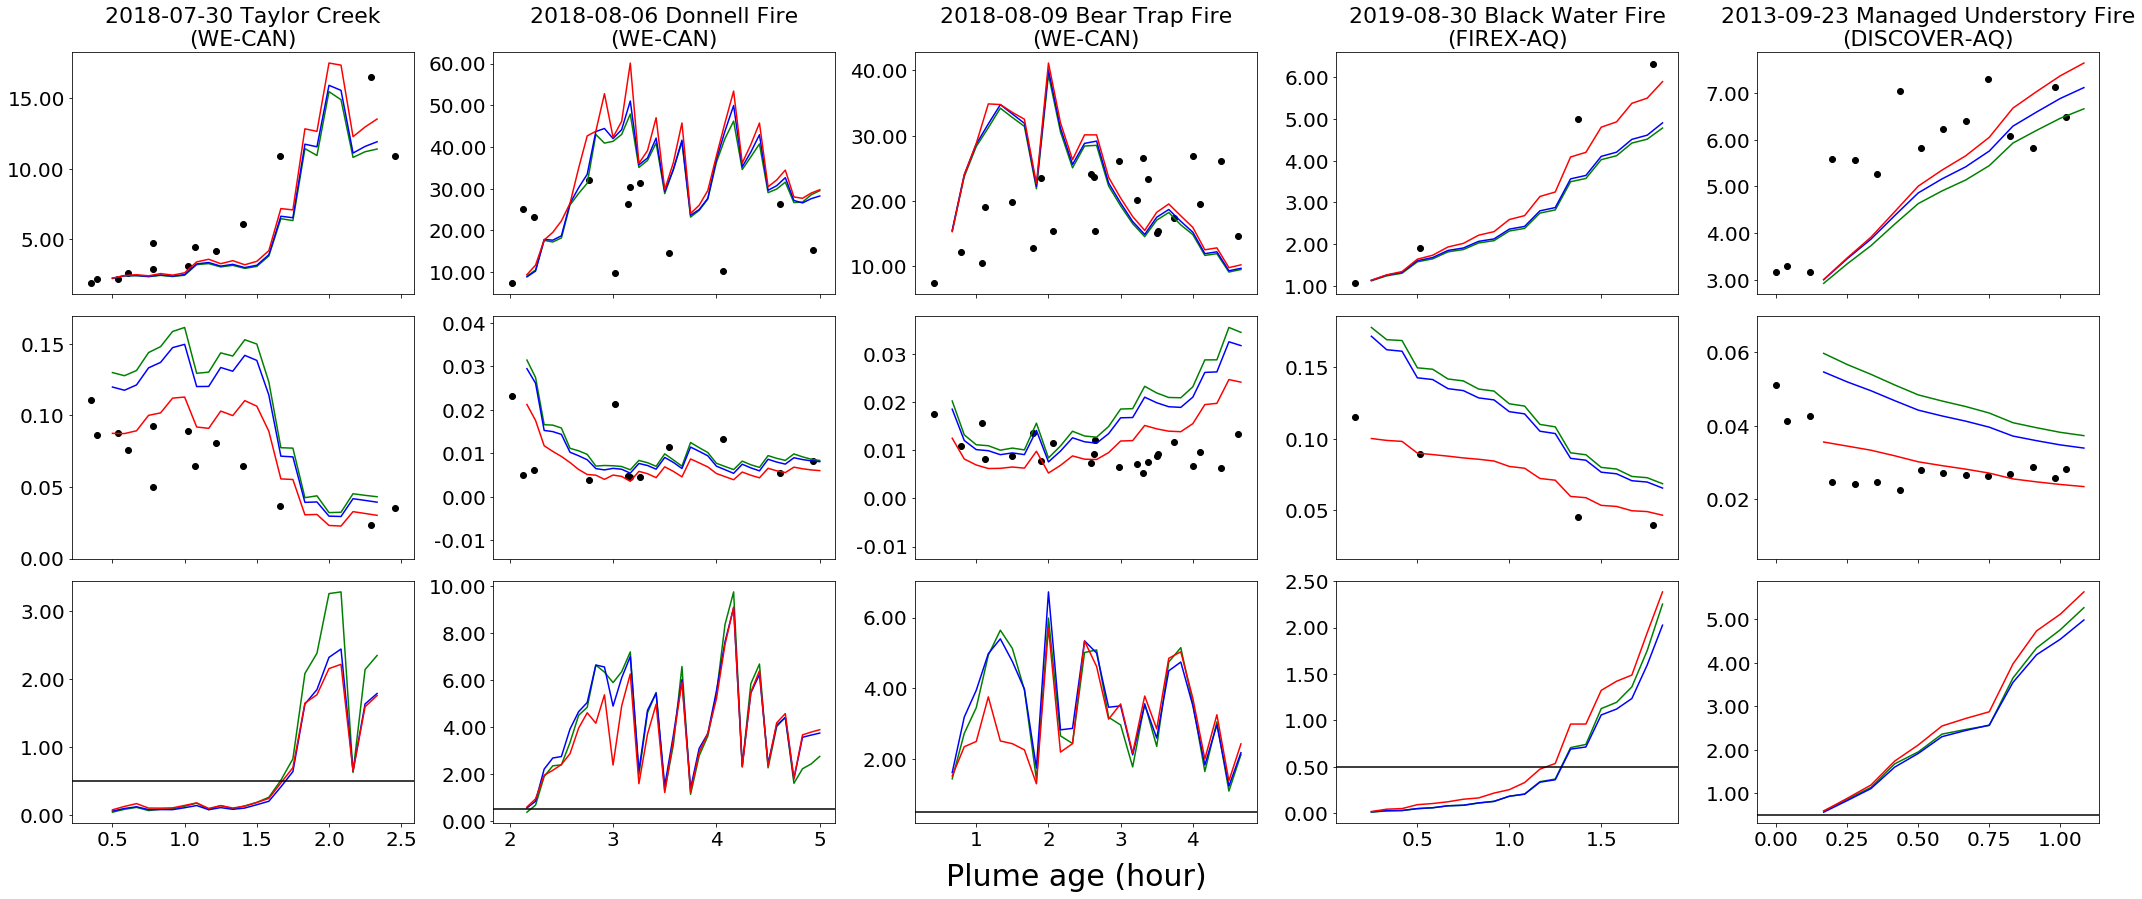

In [4]:
# Read compounds and each flight dataframe
Flight_IDs = ['RF03', 'RF07', 'RF09', 'FN19', 'P-3B']

# Define the subplot labels
subplot_labels = ['(a)', '(b)', '(c)', '(d)', 
                  '(e)', '(f)', '(g)', '(h)']


# Different targets for each row
targets = [
    #('NEMR(O3)', 'Physical age', 'smk'),
    ('CH2O vs NO2', 'Physical age', 'smk'),
    ('OHRnox vs OHRvoc', 'Physical age', 'smk'),
    ('LROx vs LNOx_broad', 'Physical age', 'smk'),
    #('Ln vs Q', 'Physical age', 'smk'),
    #('H2O2 vs HNO3', 'Physical age', 'smk'),
]


# subplots: 4 rows (for each target combination) and 5 columns (for each Flight)
fig, axes = plt.subplots(len(targets), len(Flight_IDs), 
                         figsize=(6 * len(Flight_IDs), 4 * len(targets)),
                         sharex='col')

# Iterate over each row (target combination) and column (Flight ID)
for row, (target_y, target_x, postfix) in enumerate(targets):
    print(f'Testing {target_y} and {target_x}')
    for col, Flight_ID in enumerate(Flight_IDs):
        #print(Flight_ID)
        # Set up the starting point
        # File directory, auto change for each flight ID
        if Flight_ID in ['RF03', 'RF07', 'RF09']:file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Dataprocess/analysis_bycompound/'
        if Flight_ID in ['FN19']: file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/FIREX-AQ/Dataprocess/analysis_bycompound/'
        if Flight_ID in ['P-3B']: file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/P-3B/Dataprocess/analysis_bycompound/'
        file_prefix_PL  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/PL_budget/output/'

        # --------------
        # Reading data
        # Set up x and y
        # --------------
        # ! Initial CO
        # Read CO smk data
        data_CO_smk_init = pd.read_csv(f'{file_prefix_conc}CO/{Flight_ID}_obs_smk.csv', index_col=0)['Observation'].iloc[0]
        # !! Observation
        df_obs_nemr_o3 = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init
        
        df_obs_nemr_ox = (pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                          pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_obs_smk_dil.csv', index_col=0)) / data_CO_smk_init
        
        # Missing organic nitrates (not sure what it means in WE-CAN paper, confusing usage)
        df_obs_nemr_noz = (pd.read_csv(f'{file_prefix_conc}PAN/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}PPN/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}HNO3/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}pNO3/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}pNO3/{Flight_ID}_obs_smk_dil.csv', index_col=0))/data_CO_smk_init  # use it as the observed organic nitrates excludign PPN + PAN (which is called PANs)
        
        df_obs_o3      = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_no      = pd.read_csv(f'{file_prefix_conc}NO/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_no2     = pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_nox     = pd.read_csv(f'{file_prefix_conc}NOx/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_pan     = pd.read_csv(f'{file_prefix_conc}PAN/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_ch2o    = pd.read_csv(f'{file_prefix_conc}Formaldehyde/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_ch2o_no2=df_obs_ch2o.div(df_obs_no2)
        
        if target_y in ['TVOCR', 'OHRvoc vs OHRnox', 'OHRnox vs OHRvoc'] or target_x in ['TVOCR', 'OHRvoc vs OHRnox', 'OHRnox vs OHRvoc']:
            df_obs_vocr = VOCR_reader_cases(Flight_ID=Flight_ID, get_smk_dil=(postfix == 'smk_dil'), get_smk_conc=(postfix == 'smk'))
            df_obs_OHRnox        = (df_obs_no*9.7605E-12 + df_obs_no2*9.8258E-12)*2.46e10
            df_obs_OHRvoc_OHRnox = df_obs_vocr.div(df_obs_OHRnox)
            df_obs_OHRnox_OHRvoc = df_obs_OHRnox.div(df_obs_vocr)
        else: # speed up the code
            df_obs_vocr = [np.nan]*len(df_obs_o3)
            df_obs_OHRnox = [np.nan]*len(df_obs_o3)
            df_obs_OHRvoc_OHRnox = [np.nan]*len(df_obs_o3)
            df_obs_OHRnox_OHRvoc = [np.nan]*len(df_obs_o3)
        # !! Model
        df_mod_nemr_o3 = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_ox = (pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                          pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_mod_smk_dil.csv', index_col=0)) / data_CO_smk_init
        
        df_obs_nemr_noz = (pd.read_csv(f'{file_prefix_conc}HNO3/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}HNO4/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}pNO3/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}pNO3/{Flight_ID}_mod_smk_dil.csv', index_col=0))/data_CO_smk_init  # use it as the observed organic nitrates excludign PPN + PAN (which is called PANs)

        
                          
        df_mod_o3      = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_no      = pd.read_csv(f'{file_prefix_conc}NO/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_no2     = pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_nox     = pd.read_csv(f'{file_prefix_conc}NOx/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_pan     = pd.read_csv(f'{file_prefix_conc}PAN/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ch2o    = pd.read_csv(f'{file_prefix_conc}Formaldehyde/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ch2o_no2= df_mod_ch2o.div(df_mod_no2)
        
        df_mod_vocr          = pd.read_csv(f'{file_prefix_conc}TVOCR/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_vocr.index    = df_mod_no.index
        df_mod_OHRnox        = (df_mod_no*9.7605E-12 + df_mod_no2*9.8258E-12)*2.46e10
        df_mod_OHRvoc_OHRnox = df_mod_vocr.div(df_mod_OHRnox) 
        df_mod_OHRnox_OHRvoc = df_mod_OHRnox.div(df_mod_vocr) 
        df_mod_ho2 = pd.read_csv(f'{file_prefix_conc}HO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ro2 = pd.read_csv(f'{file_prefix_conc}TRO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        
        # !! Model results
        # L(ROx)/L(NOx_broad)
        df_mod_nox_broad_loss = pd.read_csv(f'{file_prefix_PL}NOx_broad/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)
        df_mod_rox_loss       = pd.read_csv(f'{file_prefix_PL}ROx/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)   
        df_mod_Lrox_Lnox_broad= df_mod_rox_loss.div(df_mod_nox_broad_loss)
        '''
        # test
        print(Flight_ID)
        print(df_mod_nox_broad_loss['GEOS-Chem (base)'].mean())
        print(df_mod_nox_broad_loss['MCM + GEOS-Chem VOCs'].mean())
        print(df_mod_nox_broad_loss['MCM + FUR'].mean())
        continue
        '''
        # Ln/Q
        df_mod_hno3_prod = pd.read_csv(f'{file_prefix_PL}HNO3/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
        df_mod_hno4_prod = pd.read_csv(f'{file_prefix_PL}HNO4/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
        df_mod_pns_prod  = pd.read_csv(f'{file_prefix_PL}PNs/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
        df_mod_ans_prod  = pd.read_csv(f'{file_prefix_PL}ANs/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
        df_mod_Ln    = -(df_mod_hno3_prod + df_mod_hno4_prod + df_mod_pns_prod + df_mod_ans_prod)
        #df_mod_Ln   = pd.read_csv(f'{file_prefix_PL}NOx/{Flight_ID}_Loss_rates.csv', index_col=0)   
        df_mod_Q     = df_mod_Ln + df_mod_rox_loss
        df_mod_Ln_Q  = df_mod_Ln.div(df_mod_Q)

        # H2O2/HNO3
        df_mod_h2o2      = pd.read_csv(f'{file_prefix_conc}H2O2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_hno3      = pd.read_csv(f'{file_prefix_conc}HNO3/{Flight_ID}_mod_{postfix}.csv', index_col=0)

        # work aournd
        df_mod_hno3.index = df_mod_h2o2.index
        df_mod_h2o2_hno3 = df_mod_h2o2.div(df_mod_hno3)
        
        # OPE
        df_mod_o3_prod    = pd.read_csv(f'{file_prefix_PL}O3/{Flight_ID}_Production_rates_evolution.csv', index_col=0)
        df_mod_ox_prod    = pd.read_csv(f'{file_prefix_PL}Ox/{Flight_ID}_Production_rates_evolution.csv', index_col=0)
        df_mod_ox_loss    = pd.read_csv(f'{file_prefix_PL}Ox/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)
        df_mod_ox_netprod = df_mod_ox_prod + df_mod_ox_loss
        df_mod_nox_loss   = pd.read_csv(f'{file_prefix_PL}NOx/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)   

        # OH evaluation
        # observation and model for OH or chemical age
        df_obs_cal_OH, df_mod_cal_OH, df_mod_ = calculate_oh_chem_age_stats(voc_names, file_prefix_conc, Flight_ID, 0)    
        # make df_obs_cal_OH as a dataframe with observation...
        df_obs_cal_OH = pd.DataFrame(df_obs_cal_OH['Median']).rename(columns={'Median': 'Observation'})

        # Get chemical age
        df_obs_cal_chem_age, df_mod_cal_chem_age, df_mod_output_chem_age = calculate_oh_chem_age_stats(voc_names, file_prefix_conc, Flight_ID, 1)    
        # make df_obs_cal_OH as a dataframe with observation...
        df_obs_cal_chem_age = pd.DataFrame(df_obs_cal_chem_age['Median']).rename(columns={'Median': 'Observation'})

        # ---------------------
        # Data processing
        # standardize, bin time
        # ---------------------
        standard_index = df_mod_o3_prod.index.values if target_y in ['PO3', 'POx', 'net POx', 'OPE', 'Ln', 'LROx', 'Ln vs Q', 'LNOx_broad', 'LROx vs LNOx_broad'] else df_mod_o3.index.values    
        # Concentration
        df_mod_o3_interp            = interp(df_mod_o3, standard_index)
        df_mod_nemr_o3_interp       = interp(df_mod_nemr_o3, standard_index)
        df_mod_nemr_ox_interp       = interp(df_mod_nemr_ox, standard_index)
        df_mod_no_interp            = interp(df_mod_no, standard_index)
        df_mod_no2_interp           = interp(df_mod_no2, standard_index)
        df_mod_nox_interp           = interp(df_mod_nox, standard_index)
        df_mod_pan_interp           = interp(df_mod_pan, standard_index)
        df_mod_ch2o_interp          = interp(df_mod_ch2o, standard_index)
        df_mod_ch2o_no2_interp      = interp(df_mod_ch2o_no2, standard_index)
        df_mod_vocr_interp          = interp(df_mod_vocr, standard_index)
        df_mod_OHRnox_interp        = interp(df_mod_OHRnox, standard_index)
        df_mod_OHRvoc_OHRnox_interp = interp(df_mod_OHRvoc_OHRnox, standard_index)
        df_mod_OHRnox_OHRvoc_interp = interp(df_mod_OHRnox_OHRvoc, standard_index)
        df_mod_cal_OH_interp         = interp(df_mod_cal_OH, standard_index)
        #df_mod_output_OH_interp      = interp(df_mod_output_OH, standard_index)
        df_mod_cal_chem_age_interp   = interp(df_mod_cal_chem_age, standard_index)
        df_mod_output_chem_age_interp= interp(df_mod_output_chem_age, standard_index)

        df_mod_ho2_interp           = interp(df_mod_ho2, standard_index)
        df_mod_ro2_interp           = interp(df_mod_ro2, standard_index)
        # L(ROx)/L(NOx_broad)
        df_mod_nox_broad_loss_interp = interp(df_mod_nox_broad_loss, standard_index)
        df_mod_rox_loss_interp       = interp(df_mod_rox_loss, standard_index)
        df_mod_Lrox_Lnox_broad_interp= interp(df_mod_Lrox_Lnox_broad, standard_index)
        # Ln/Q
        df_mod_Ln_interp             = interp(df_mod_Ln, standard_index)
        df_mod_Q_interp              = interp(df_mod_Q, standard_index)
        df_mod_Ln_Q_interp           = interp(df_mod_Ln_Q, standard_index)

        # H2O2/HNO3
        df_mod_h2o2_interp           = interp(df_mod_h2o2, standard_index)
        df_mod_hno3_interp           = interp(df_mod_hno3, standard_index)
        df_mod_h2o2_hno3_interp      = interp(df_mod_h2o2_hno3, standard_index)
        
        # OPE
        df_mod_o3_prod_interp        = interp(df_mod_o3_prod, standard_index)
        df_mod_ox_prod_interp        = interp(df_mod_ox_prod, standard_index)
        df_mod_ox_netprod_interp     = interp(df_mod_ox_netprod, standard_index)
        df_mod_nox_loss_interp       = interp(df_mod_nox_loss, standard_index)

        # ------------
        # Bin the data
        # ------------
        if 'RF' not in Flight_ID: interval = 5
        if Flight_ID == 'RF03': interval = 5
        if Flight_ID == 'RF07': interval = 5
        if Flight_ID == 'RF09': interval = 10
        df_mod_o3_bin     = bin_df(df_mod_o3_interp,interval).iloc[1:]
        df_mod_nemr_o3_bin= bin_df(df_mod_nemr_o3_interp,interval).iloc[1:]
        df_mod_nemr_ox_bin= bin_df(df_mod_nemr_ox_interp,interval).iloc[1:]
        df_mod_no_bin     = bin_df(df_mod_no_interp,interval).iloc[1:]
        df_mod_no2_bin    = bin_df(df_mod_no2_interp,interval).iloc[1:]
        df_mod_nox_bin    = bin_df(df_mod_nox_interp,interval).iloc[1:]
        df_mod_pan_bin    = bin_df(df_mod_pan_interp,interval).iloc[1:]
        df_mod_ch2o_bin   = bin_df(df_mod_ch2o_interp,interval).iloc[1:]
        df_mod_ch2o_no2_bin= bin_df(df_mod_ch2o_no2_interp,interval).iloc[1:]
        df_mod_vocr_bin   = bin_df(df_mod_vocr_interp,interval).iloc[1:]
        df_mod_OHRnox_bin = bin_df(df_mod_OHRnox_interp,interval).iloc[1:]
        df_mod_OHRvoc_OHRnox_bin = bin_df(df_mod_OHRvoc_OHRnox_interp,interval).iloc[1:]
        df_mod_OHRnox_OHRvoc_bin = bin_df(df_mod_OHRnox_OHRvoc_interp,interval).iloc[1:]
        #df_mod_output_OH_bin      = bin_df(df_mod_output_OH_interp, interval).iloc[1:]
        df_mod_output_chem_age_bin= bin_df(df_mod_output_chem_age_interp, interval).iloc[1:]
        df_mod_ho2_bin      = bin_df(df_mod_ho2_interp, interval).iloc[1:]
        df_mod_ro2_bin      = bin_df(df_mod_ro2_interp, interval).iloc[1:]

        # Special implementation for calculated OH/chemical age. The VOCs selected in this case is not in the CTMs thus we have to assume all experients shared the same calculated values
        # Make the Chemical age bin the same pattern as other simulations
        df_mod_cal_OH_bin_dummy  = bin_df(df_mod_cal_OH_interp, interval).iloc[1:] # this is only application for MCMBBVOC
        df_mod_cal_chem_age_bin_dummy  = bin_df(df_mod_cal_chem_age_interp, interval).iloc[1:] # this is only application for MCMBBVOC
        dummy_cols = ['GEOS-Chem (base)', 'GEOS-Chem + FUR', 'MCM + FUR', 'MCM + GEOS-Chem VOCs']
        # Create a new DataFrame with repeated median and IQR values across specified columns
        df_mod_cal_chem_age_bin = pd.DataFrame(index=df_mod_cal_chem_age_bin_dummy.index, columns=pd.MultiIndex.from_product([dummy_cols, ['median', 'iqr']]))
        df_mod_cal_OH_bin = pd.DataFrame(index=df_mod_cal_OH_bin_dummy.index, columns=pd.MultiIndex.from_product([dummy_cols, ['median', 'iqr']]))
        for column in dummy_cols:
            df_mod_cal_chem_age_bin[(column, 'median')], df_mod_cal_chem_age_bin[(column, 'iqr')] = df_mod_cal_chem_age_bin_dummy['Median', 'median'], df_mod_cal_chem_age_bin_dummy['Median', 'iqr']
            df_mod_cal_OH_bin[(column, 'median')], df_mod_cal_OH_bin[(column, 'iqr')] = df_mod_cal_OH_bin_dummy['Median', 'median'], df_mod_cal_OH_bin_dummy['Median', 'iqr']

        # L(ROx)/L(NOx_broad)
        df_mod_nox_broad_loss_bin = bin_df(df_mod_nox_broad_loss_interp, interval).iloc[1:]
        df_mod_rox_loss_bin       = bin_df(df_mod_rox_loss_interp, interval).iloc[1:]
        df_mod_Lrox_Lnox_broad_bin= bin_df(df_mod_Lrox_Lnox_broad_interp, interval).iloc[1:]
        
        
        # H2O2/HNO3
        df_mod_h2o2_bin           = bin_df(df_mod_h2o2_interp, interval).iloc[1:]
        df_mod_hno3_bin           = bin_df(df_mod_hno3_interp, interval).iloc[1:]
        df_mod_h2o2_hno3_bin      = bin_df(df_mod_h2o2_hno3_interp, interval).iloc[1:]        
        # Ln/Q
        df_mod_Ln_bin             = bin_df(df_mod_Ln_interp, interval).iloc[1:]
        df_mod_Q_bin              = bin_df(df_mod_Q_interp, interval).iloc[1:]
        df_mod_Ln_Q_bin           = bin_df(df_mod_Ln_Q_interp, interval).iloc[1:]
        # OPE
        df_mod_o3_prod_bin        = bin_df(df_mod_o3_prod_interp, interval).iloc[1:]
        df_mod_ox_prod_bin        = bin_df(df_mod_ox_prod_interp, interval).iloc[1:]
        df_mod_ox_netprod_bin     = bin_df(df_mod_ox_netprod_interp, interval).iloc[1:]
        df_mod_nox_loss_bin       = bin_df(df_mod_nox_loss_interp, interval).iloc[1:]
        
        # --------------------
        # Select targt x and y
        # --------------------
        # Dictionary mapping targets to their corresponding dataframes
        dataframes_mapping = {
            'NO':              (df_obs_no, df_mod_no_bin),
            'NO2':             (df_obs_no2, df_mod_no2_bin),
            'NOx':             (df_obs_nox, df_mod_nox_bin),
            'PAN':             (df_obs_pan, df_mod_pan_bin),
            'CH2O':            (df_obs_ch2o, df_mod_ch2o_bin),
            'CH2O vs NO2':     (df_obs_ch2o_no2, df_mod_ch2o_no2_bin),
            'TVOCR':           (df_obs_vocr, df_mod_vocr_bin),
            'Ozone':           (df_obs_o3, df_mod_o3_bin),
            'NEMR(O3)':        (df_obs_nemr_o3, df_mod_nemr_o3_bin),
            'NEMR(Ox)':        (df_obs_nemr_ox, df_mod_nemr_ox_bin),
            'OHRnox':          (df_obs_OHRnox, df_mod_OHRnox_bin),
            'OHRvoc vs OHRnox':(df_obs_OHRvoc_OHRnox, df_mod_OHRvoc_OHRnox_bin),
            'OHRnox vs OHRvoc':(df_obs_OHRnox_OHRvoc, df_mod_OHRnox_OHRvoc_bin),
            'Physical age':    (df_obs_o3.assign(Observation=df_obs_o3.index)/60,
                                df_mod_o3_bin.apply(lambda col_test: df_mod_o3_bin.index if 'median' in col_test.name else 0, axis=0)/60),
            'Chemical age':      (df_obs_cal_chem_age, df_mod_cal_chem_age_bin), 
            #'OH analysis':       (df_obs_cal_OH, df_mod_output_OH_bin), # !!! This is specailly set and can be modified for own purpose!!!
            'LROx':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_rox_loss_bin),
            'LNOx_broad':        (df_obs_o3.applymap(lambda x: np.nan), df_mod_nox_broad_loss_bin),
            'LROx vs LNOx_broad':(df_obs_o3.applymap(lambda x: np.nan), df_mod_Lrox_Lnox_broad_bin),
            'H2O2':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_h2o2_bin),
            'HNO3':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_hno3_bin),
            'H2O2 vs HNO3':      (df_obs_o3.applymap(lambda x: np.nan), df_mod_h2o2_hno3_bin),
            'Ln':                (df_obs_o3.applymap(lambda x: np.nan), df_mod_Ln_bin),
            'Q':                 (df_obs_o3.applymap(lambda x: np.nan), df_mod_Q_bin),
            'Ln vs Q':           (df_obs_o3.applymap(lambda x: np.nan), df_mod_Ln_Q_bin),
            'PO3':               (df_obs_o3.applymap(lambda x: np.nan), df_mod_o3_prod_bin),
            'POx':               (df_obs_o3.applymap(lambda x: np.nan), df_mod_ox_prod_bin),
            'net POx':           (df_obs_o3.applymap(lambda x: np.nan), df_mod_ox_netprod_bin),
            'LNOx':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_nox_loss_bin),
        }
        
        
        # Select target x and y
        df_x_obs, df_x_mod = dataframes_mapping.get(target_x, (None, None))
        df_y_obs, df_y_mod = dataframes_mapping.get(target_y, (None, None))
        # Replace the 0 as nan in the observation data
        df_x_obs['Observation'] = df_x_obs['Observation'].replace(0, np.nan)
        df_y_obs['Observation'] = df_y_obs['Observation'].replace(0, np.nan)
        
        # --------
        # Plotting
        # --------
        ax = axes[row, col]
        # Observations
        if not ((df_x_obs['Observation'].eq(0)).all()) and \
            not (df_x_obs['Observation'].isna().all()) and \
            not ((df_x_obs['Observation'].eq(0)).all()) and \
            not (df_y_obs['Observation'].isna().all()):
            ax.scatter(df_x_obs['Observation'], df_y_obs['Observation'], 
                              label = 'Obs', color = 'black')
            '''
            # Perform linear regression
            idx = np.isfinite(df_x_obs['Observation']) & np.isfinite(df_y_obs['Observation'])
            slope, intercept = np.polyfit(df_x_obs['Observation'][idx], df_y_obs['Observation'][idx], 1)

            # Calculate R-squared
            correlation_matrix = np.corrcoef(df_x_obs['Observation'][idx], df_y_obs['Observation'][idx])
            correlation_xy = correlation_matrix[0,1]
            r_squared = correlation_xy**2

            # Plot regression line
            x_vals = np.array(ax.get_xlim())
            y_vals = intercept + slope * x_vals
            ax.plot(x_vals, y_vals, '--', color='gray')

            # Annotate with slope and R-squared
            ax.text(0.05, 0.95, f'Slope: {slope:.2f}\n$R^2$: {r_squared:.2f}', transform=ax.transAxes, 
                           fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

            '''
            
        # Model results
        ax.plot(df_x_mod['GEOS-Chem (base)', 'median'].tolist(), df_y_mod['GEOS-Chem (base)', 'median'],
                       color=colors[0], label='$GC$')#, marker='o')  # Line plot with markers
        ax.plot(df_x_mod['MCM + GEOS-Chem VOCs', 'median'].tolist(), df_y_mod['MCM + GEOS-Chem VOCs', 'median'],
                       color=colors[3], label='$MCM_{GCVOC}$')#, marker='o')  # Line plot with markers
        ax.plot(df_x_mod['MCM + FUR', 'median'].tolist(), df_y_mod['MCM + FUR', 'median'],
                       color=colors[2], label='$MCM_{BBVOC}$')#, marker='o')  # Line plot with marker
        '''
        if col == 0: 
            print(df_y_mod['GEOS-Chem (base)', 'median'].mean())
            print(df_y_mod['MCM + GEOS-Chem VOCs', 'median'].mean())
            print(df_y_mod['MCM + FUR', 'median'].mean())
        '''
        # start from 0
        #ax.set_ylim(bottom=0)
        # ----------------------------------
        # Texts for slope and R square value
        # ---------------------------------
        # set up the row
        if row==0: ax.set_title(id2fire_name[Flight_ID], loc ='center', size=fontsize_flight*1.1)
        
        ax.tick_params(axis='both', labelsize=fontsize_tick)

        # Format y-axis tick labels to two decimal places
        #if target_y == 'NEMR(O3)': ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        # Set x-axis ticks and labels with an interval of 0.5
        
        # Start with the default tick positions
        #if target_x == 'Physical age':
        #    if Flight_ID == 'RF03': new_ticks = np.arange(0, 2.5 + 0.5, 0.5)
        #    if Flight_ID == 'RF07': new_ticks = np.arange(2, 5.5 + 0.5, 0.5)
        #    if Flight_ID == 'RF09': new_ticks = np.arange(0, 5.0 + 0.5, 0.5)
        #    if Flight_ID == 'FN19': new_ticks = np.arange(0, 1.5 + 0.5, 0.5)
        #    if Flight_ID == 'P-3B': new_ticks = np.arange(0, 1.0 + 0.5, 0.5)
        #    ax.set_xticks(new_ticks)
        #    ax.set_xticklabels([f"{tick:.1f}" for tick in new_ticks], rotation=30)
        #    # Set the x-axis limits
        #    ax.set_xlim([min(new_ticks), max(new_ticks)])

        # -------------------------------------
        # Calculate the model: observation bias
        # -------------------------------------
        if not ((df_x_obs['Observation'].eq(0)).all()) and \
            not (df_x_obs['Observation'].isna().all()) and \
            not ((df_x_obs['Observation'].eq(0)).all()) and \
            not (df_y_obs['Observation'].isna().all()):
            # Polinomial regression line
            # train the model based on observation data
            idx = np.isfinite(df_x_obs['Observation']) & np.isfinite(df_y_obs['Observation'])         # only pass datapoint with values
            coefs = np.polyfit(df_x_obs['Observation'][idx], df_y_obs['Observation'][idx], 2) # 3 may be the best fit
            poly_model = np.poly1d(coefs)
            # text for observations
            relative_diff1 = (df_y_mod['GEOS-Chem (base)', 'median']-poly_model(df_x_mod['GEOS-Chem (base)', 'median']))/poly_model(df_x_mod['GEOS-Chem (base)', 'median']) * 100       
            relative_diff1 = relative_diff1
            abs_diff1 = df_y_mod['GEOS-Chem (base)', 'median']-poly_model(df_x_mod['GEOS-Chem (base)', 'median'])

            relative_diff3 = (df_y_mod['MCM + GEOS-Chem VOCs', 'median']-poly_model(df_x_mod['MCM + GEOS-Chem VOCs', 'median']))/poly_model(df_x_mod['MCM + GEOS-Chem VOCs', 'median']) * 100       
            relative_diff3 = relative_diff3
            abs_diff3 = df_y_mod['MCM + GEOS-Chem VOCs', 'median']-poly_model(df_x_mod['MCM + GEOS-Chem VOCs', 'median'])

            relative_diff4 = (df_y_mod['MCM + FUR', 'median']-poly_model(df_x_mod['MCM + FUR', 'median']))/poly_model(df_x_mod['MCM + FUR', 'median']) * 100   
            relative_diff4 = relative_diff4 
            abs_diff4 = df_y_mod['MCM + FUR', 'median']-poly_model(df_x_mod['MCM + FUR', 'median'])

            # median of the diff
            relative_diff1 = np.nanmedian(relative_diff1)
            relative_diff3 = np.nanmedian(relative_diff3)
            relative_diff4 = np.nanmedian(relative_diff4)
            abs_diff1 = np.nanmedian(abs_diff1)
            abs_diff3 = np.nanmedian(abs_diff3)
            abs_diff4 = np.nanmedian(abs_diff4)

            # last data point of the diff
            diff_str1   = '{:.0f}'.format(abs_diff1) + 'ppb (' + '{:.0f}'.format(relative_diff1) +'%)'
            diff_str3   = '{:.0f}'.format(abs_diff3) + 'ppb (' + '{:.0f}'.format(relative_diff3) +'%)'
            diff_str4   = '{:.0f}'.format(abs_diff4) + 'ppb (' + '{:.0f}'.format(relative_diff4) +'%)'

            # Texts
            # get the range for the x/y axis
            if row == 0:
                xmin, xmax = ax.get_xlim()
                ymin, ymax = ax.get_ylim()
            
                #xmin, xmax = df_x_mod['MCM + GEOS-Chem VOCs', 'median'].min(), df_x_mod['MCM + GEOS-Chem VOCs', 'median'].max()
                #ymin, ymax = df_y_mod['MCM + GEOS-Chem VOCs', 'median'].min(), df_y_mod['MCM + GEOS-Chem VOCs', 'median'].max()

            #if target_x in Comps_in_GC and target_y in Comps_in_GC:
            #    ax.text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.32+ymin, diff_str1, fontsize=fontsize_tick, color = colors[0])  
            #    ax.text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.22+ymin, diff_str3, fontsize=fontsize_tick, color = colors[3])  
            #ax.text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.12+ymin, diff_str4, fontsize=fontsize_tick, color = colors[2])
        
        if target_y== 'LROx vs LNOx_broad':
            # Get the current limits of the x-axis    
            ax.axhline(y=0.5, color='black', linestyle='-')  
            # Add text above and below the line
            #text_position_above = 0.5  # Slightly above the line
            #text_position_below = 0.5  # Slightly below the line
            #ax.text((xmax-xmin)*0.15+xmin, y=text_position_above,  va='top', s='↑ VOC limited', fontsize=12)
            #ax.text((xmax-xmin)*0.15+xmin, y=text_position_below,  va='bottom', s='↓ NO$_{x}$ limited', fontsize=12)
        
        if target_y== 'Ln vs Q':
            # Get the current limits of the x-axis    
            ax.axhline(y=1, color='black', linestyle='-')  

        if target_y=='H2O2 vs HNO3':
            # Get the current limits of the x-axis    
            ax.axhline(y=0.4, color='black', linestyle='-')
            
    # Add y-axis labels for each row
    if col ==0: 
        ax.set_ylabel(text_labels.get(target_y, target_y), fontsize=fontsize_comp*1.5)
        fig.align_ylabels(ax)  # Align y-labels for each row
    
        # Add subplot labels for the first column of each row
        #ax.text(0.15, 0.95, subplot_labels[row], 
        #               transform=ax.transAxes, 
        #                fontsize=20, fontweight='bold', va='top', ha='right')



        # Mute the legend
        legend = ax.legend(loc='center right', fontsize=11.2)
        legend.set_bbox_to_anchor((1, 0.23))  # Adjust the x-location here (1.1 is an example, you can adjust it further as needed)        
        if (row, col) != (0, 0): ax.legend().set_visible(False)
        # Spacing Out
        plt.subplots_adjust(wspace=.1, hspace=.05)
# Adjust subplot layout
plt.subplots_adjust(wspace=0.05, hspace=0.00)
# Set x and y labels for the entire figure
fig.text(0.5, -0.02, 'Plume age (hour)', ha='center', va='center', fontsize=30)

# Set figure title
#fig.suptitle('Figure Title', fontsize=35)

plt.tight_layout()
plt.show()

Testing CH2O vs NO2 and Chemical age
Testing OHRnox vs OHRvoc and Chemical age
NO 2,3-butanedione EXIST!
NO Maleic Anhydride EXIST!
NO propanal EXIST!
Testing LROx vs LNOx_broad and Chemical age


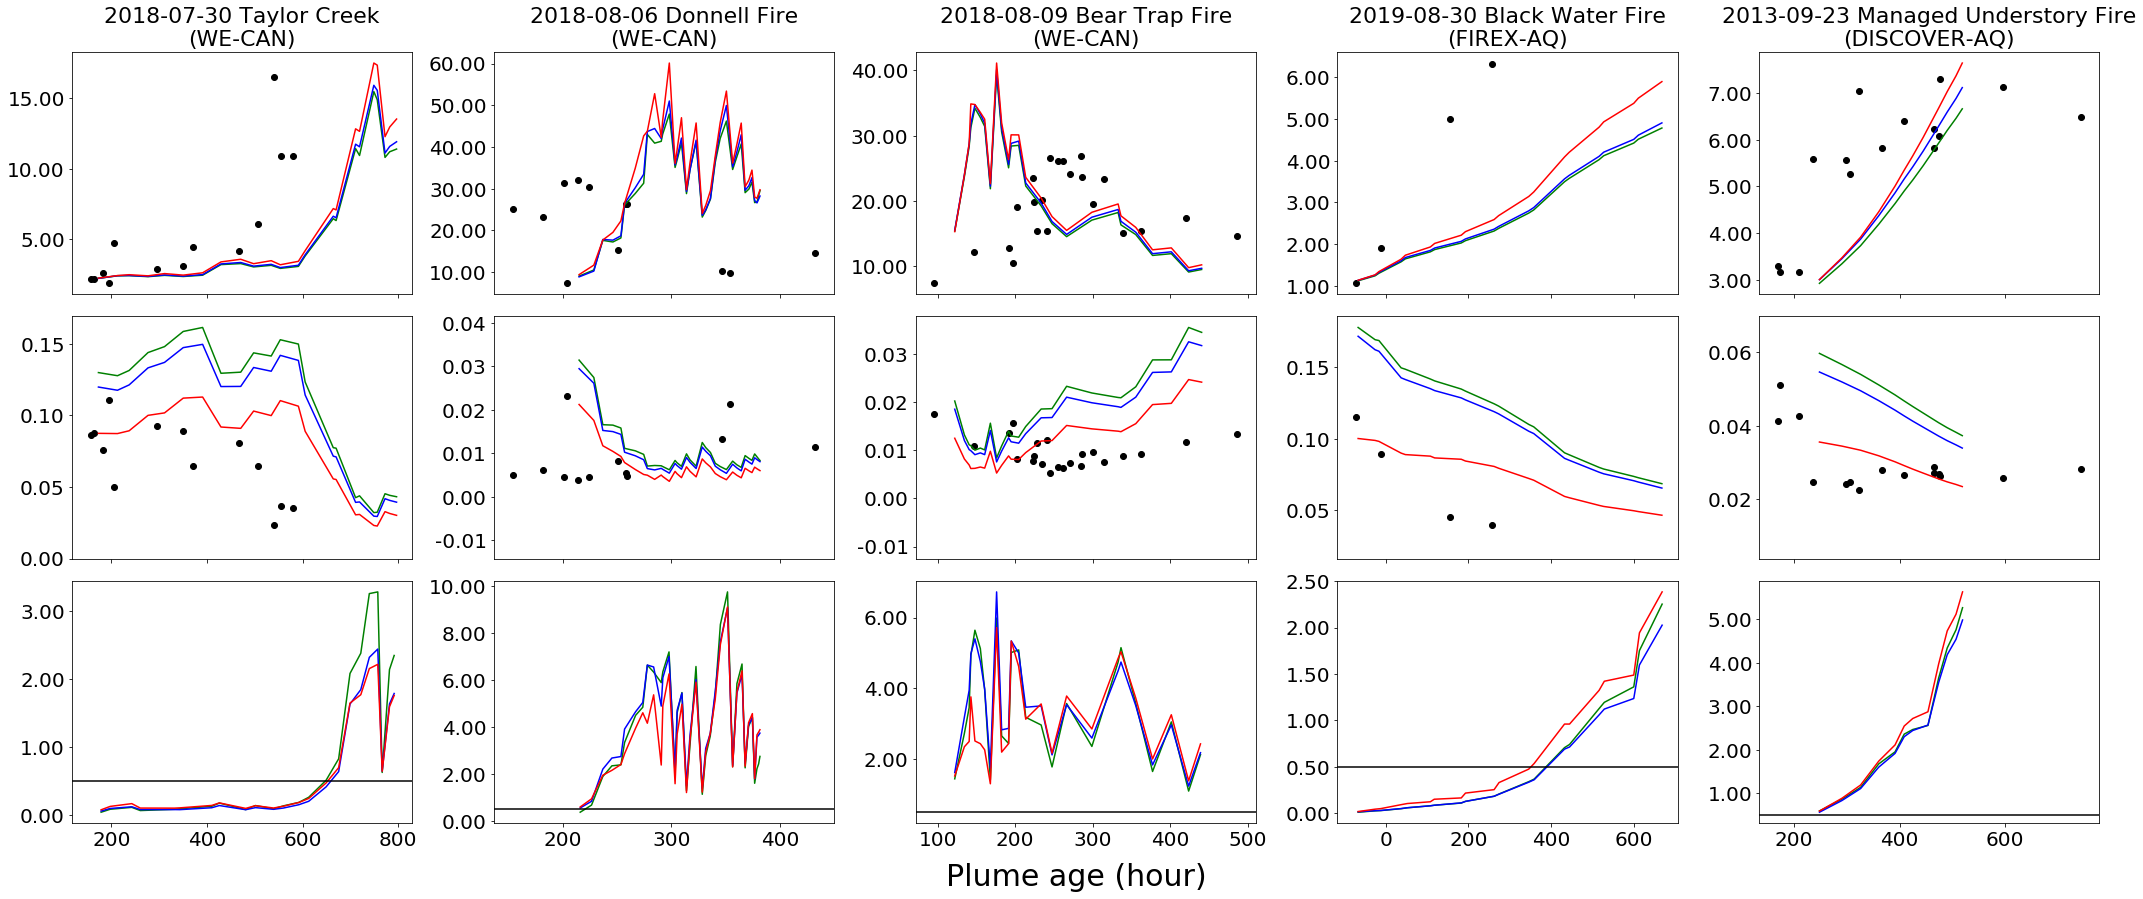

In [5]:
# Read compounds and each flight dataframe
Flight_IDs = ['RF03', 'RF07', 'RF09', 'FN19', 'P-3B']

# Define the subplot labels
subplot_labels = ['(a)', '(b)', '(c)', '(d)', 
                  '(e)', '(f)', '(g)', '(h)']


# Different targets for each row
targets = [
    #('NEMR(O3)', 'Physical age', 'smk'),
    ('CH2O vs NO2', 'Chemical age', 'smk'),
    ('OHRnox vs OHRvoc', 'Chemical age', 'smk'),
    ('LROx vs LNOx_broad', 'Chemical age', 'smk'),
    #('Ln vs Q', 'Physical age', 'smk'),
    #('H2O2 vs HNO3', 'Physical age', 'smk'),
]


# subplots: 4 rows (for each target combination) and 5 columns (for each Flight)
fig, axes = plt.subplots(len(targets), len(Flight_IDs), 
                         figsize=(6 * len(Flight_IDs), 4 * len(targets)),
                         sharex='col')

# Iterate over each row (target combination) and column (Flight ID)
for row, (target_y, target_x, postfix) in enumerate(targets):
    print(f'Testing {target_y} and {target_x}')
    for col, Flight_ID in enumerate(Flight_IDs):
        #print(Flight_ID)
        # Set up the starting point
        # File directory, auto change for each flight ID
        if Flight_ID in ['RF03', 'RF07', 'RF09']:file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Dataprocess/analysis_bycompound/'
        if Flight_ID in ['FN19']: file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/FIREX-AQ/Dataprocess/analysis_bycompound/'
        if Flight_ID in ['P-3B']: file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/P-3B/Dataprocess/analysis_bycompound/'
        file_prefix_PL  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/PL_budget/output/'

        # --------------
        # Reading data
        # Set up x and y
        # --------------
        # ! Initial CO
        # Read CO smk data
        data_CO_smk_init = pd.read_csv(f'{file_prefix_conc}CO/{Flight_ID}_obs_smk.csv', index_col=0)['Observation'].iloc[0]
        # !! Observation
        df_obs_nemr_o3 = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init
        
        df_obs_nemr_ox = (pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                          pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_obs_smk_dil.csv', index_col=0)) / data_CO_smk_init
        
        # Missing organic nitrates (not sure what it means in WE-CAN paper, confusing usage)
        df_obs_nemr_noz = (pd.read_csv(f'{file_prefix_conc}PAN/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}PPN/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}HNO3/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}pNO3/{Flight_ID}_obs_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}pNO3/{Flight_ID}_obs_smk_dil.csv', index_col=0))/data_CO_smk_init  # use it as the observed organic nitrates excludign PPN + PAN (which is called PANs)
        
        df_obs_o3      = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_no      = pd.read_csv(f'{file_prefix_conc}NO/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_no2     = pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_nox     = pd.read_csv(f'{file_prefix_conc}NOx/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_pan     = pd.read_csv(f'{file_prefix_conc}PAN/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_ch2o    = pd.read_csv(f'{file_prefix_conc}Formaldehyde/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_ch2o_no2=df_obs_ch2o.div(df_obs_no2)
        
        if target_y in ['TVOCR', 'OHRvoc vs OHRnox', 'OHRnox vs OHRvoc'] or target_x in ['TVOCR', 'OHRvoc vs OHRnox', 'OHRnox vs OHRvoc']:
            df_obs_vocr = VOCR_reader_cases(Flight_ID=Flight_ID, get_smk_dil=(postfix == 'smk_dil'), get_smk_conc=(postfix == 'smk'))
            df_obs_OHRnox        = (df_obs_no*9.7605E-12 + df_obs_no2*9.8258E-12)*2.46e10
            df_obs_OHRvoc_OHRnox = df_obs_vocr.div(df_obs_OHRnox)
            df_obs_OHRnox_OHRvoc = df_obs_OHRnox.div(df_obs_vocr)
        else: # speed up the code
            df_obs_vocr = [np.nan]*len(df_obs_o3)
            df_obs_OHRnox = [np.nan]*len(df_obs_o3)
            df_obs_OHRvoc_OHRnox = [np.nan]*len(df_obs_o3)
            df_obs_OHRnox_OHRvoc = [np.nan]*len(df_obs_o3)
        # !! Model
        df_mod_nemr_o3 = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_ox = (pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                          pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_mod_smk_dil.csv', index_col=0)) / data_CO_smk_init
        
        df_obs_nemr_noz = (pd.read_csv(f'{file_prefix_conc}HNO3/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}HNO4/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}pNO3/{Flight_ID}_mod_smk_dil.csv', index_col=0) + \
                           pd.read_csv(f'{file_prefix_conc}pNO3/{Flight_ID}_mod_smk_dil.csv', index_col=0))/data_CO_smk_init  # use it as the observed organic nitrates excludign PPN + PAN (which is called PANs)

        
                          
        df_mod_o3      = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_no      = pd.read_csv(f'{file_prefix_conc}NO/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_no2     = pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_nox     = pd.read_csv(f'{file_prefix_conc}NOx/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_pan     = pd.read_csv(f'{file_prefix_conc}PAN/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ch2o    = pd.read_csv(f'{file_prefix_conc}Formaldehyde/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ch2o_no2= df_mod_ch2o.div(df_mod_no2)
        
        df_mod_vocr          = pd.read_csv(f'{file_prefix_conc}TVOCR/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_vocr.index    = df_mod_no.index
        df_mod_OHRnox        = (df_mod_no*9.7605E-12 + df_mod_no2*9.8258E-12)*2.46e10
        df_mod_OHRvoc_OHRnox = df_mod_vocr.div(df_mod_OHRnox) 
        df_mod_OHRnox_OHRvoc = df_mod_OHRnox.div(df_mod_vocr) 
        df_mod_ho2 = pd.read_csv(f'{file_prefix_conc}HO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ro2 = pd.read_csv(f'{file_prefix_conc}TRO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        
        # !! Model results
        # L(ROx)/L(NOx_broad)
        df_mod_nox_broad_loss = pd.read_csv(f'{file_prefix_PL}NOx_broad/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)
        df_mod_rox_loss       = pd.read_csv(f'{file_prefix_PL}ROx/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)   
        df_mod_Lrox_Lnox_broad= df_mod_rox_loss.div(df_mod_nox_broad_loss)
        '''
        # test
        print(Flight_ID)
        print(df_mod_nox_broad_loss['GEOS-Chem (base)'].mean())
        print(df_mod_nox_broad_loss['MCM + GEOS-Chem VOCs'].mean())
        print(df_mod_nox_broad_loss['MCM + FUR'].mean())
        continue
        '''
        # Ln/Q
        df_mod_hno3_prod = pd.read_csv(f'{file_prefix_PL}HNO3/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
        df_mod_hno4_prod = pd.read_csv(f'{file_prefix_PL}HNO4/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
        df_mod_pns_prod  = pd.read_csv(f'{file_prefix_PL}PNs/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
        df_mod_ans_prod  = pd.read_csv(f'{file_prefix_PL}ANs/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
        df_mod_Ln    = -(df_mod_hno3_prod + df_mod_hno4_prod + df_mod_pns_prod + df_mod_ans_prod)
        #df_mod_Ln   = pd.read_csv(f'{file_prefix_PL}NOx/{Flight_ID}_Loss_rates.csv', index_col=0)   
        df_mod_Q     = df_mod_Ln + df_mod_rox_loss
        df_mod_Ln_Q  = df_mod_Ln.div(df_mod_Q)

        # H2O2/HNO3
        df_mod_h2o2      = pd.read_csv(f'{file_prefix_conc}H2O2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_hno3      = pd.read_csv(f'{file_prefix_conc}HNO3/{Flight_ID}_mod_{postfix}.csv', index_col=0)

        # work aournd
        df_mod_hno3.index = df_mod_h2o2.index
        df_mod_h2o2_hno3 = df_mod_h2o2.div(df_mod_hno3)
        
        # OPE
        df_mod_o3_prod    = pd.read_csv(f'{file_prefix_PL}O3/{Flight_ID}_Production_rates_evolution.csv', index_col=0)
        df_mod_ox_prod    = pd.read_csv(f'{file_prefix_PL}Ox/{Flight_ID}_Production_rates_evolution.csv', index_col=0)
        df_mod_ox_loss    = pd.read_csv(f'{file_prefix_PL}Ox/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)
        df_mod_ox_netprod = df_mod_ox_prod + df_mod_ox_loss
        df_mod_nox_loss   = pd.read_csv(f'{file_prefix_PL}NOx/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)   

        # OH evaluation
        # observation and model for OH or chemical age
        df_obs_cal_OH, df_mod_cal_OH, df_mod_ = calculate_oh_chem_age_stats(voc_names, file_prefix_conc, Flight_ID, 0)    
        # make df_obs_cal_OH as a dataframe with observation...
        df_obs_cal_OH = pd.DataFrame(df_obs_cal_OH['Median']).rename(columns={'Median': 'Observation'})

        # Get chemical age
        df_obs_cal_chem_age, df_mod_cal_chem_age, df_mod_output_chem_age = calculate_oh_chem_age_stats(voc_names, file_prefix_conc, Flight_ID, 1)    
        # make df_obs_cal_OH as a dataframe with observation...
        df_obs_cal_chem_age = pd.DataFrame(df_obs_cal_chem_age['Median']).rename(columns={'Median': 'Observation'})

        # ---------------------
        # Data processing
        # standardize, bin time
        # ---------------------
        standard_index = df_mod_o3_prod.index.values if target_y in ['PO3', 'POx', 'net POx', 'OPE', 'Ln', 'LROx', 'Ln vs Q', 'LNOx_broad', 'LROx vs LNOx_broad'] else df_mod_o3.index.values    
        # Concentration
        df_mod_o3_interp            = interp(df_mod_o3, standard_index)
        df_mod_nemr_o3_interp       = interp(df_mod_nemr_o3, standard_index)
        df_mod_nemr_ox_interp       = interp(df_mod_nemr_ox, standard_index)
        df_mod_no_interp            = interp(df_mod_no, standard_index)
        df_mod_no2_interp           = interp(df_mod_no2, standard_index)
        df_mod_nox_interp           = interp(df_mod_nox, standard_index)
        df_mod_pan_interp           = interp(df_mod_pan, standard_index)
        df_mod_ch2o_interp          = interp(df_mod_ch2o, standard_index)
        df_mod_ch2o_no2_interp      = interp(df_mod_ch2o_no2, standard_index)
        df_mod_vocr_interp          = interp(df_mod_vocr, standard_index)
        df_mod_OHRnox_interp        = interp(df_mod_OHRnox, standard_index)
        df_mod_OHRvoc_OHRnox_interp = interp(df_mod_OHRvoc_OHRnox, standard_index)
        df_mod_OHRnox_OHRvoc_interp = interp(df_mod_OHRnox_OHRvoc, standard_index)
        df_mod_cal_OH_interp         = interp(df_mod_cal_OH, standard_index)
        #df_mod_output_OH_interp      = interp(df_mod_output_OH, standard_index)
        df_mod_cal_chem_age_interp   = interp(df_mod_cal_chem_age, standard_index)
        df_mod_output_chem_age_interp= interp(df_mod_output_chem_age, standard_index)

        df_mod_ho2_interp           = interp(df_mod_ho2, standard_index)
        df_mod_ro2_interp           = interp(df_mod_ro2, standard_index)
        # L(ROx)/L(NOx_broad)
        df_mod_nox_broad_loss_interp = interp(df_mod_nox_broad_loss, standard_index)
        df_mod_rox_loss_interp       = interp(df_mod_rox_loss, standard_index)
        df_mod_Lrox_Lnox_broad_interp= interp(df_mod_Lrox_Lnox_broad, standard_index)
        # Ln/Q
        df_mod_Ln_interp             = interp(df_mod_Ln, standard_index)
        df_mod_Q_interp              = interp(df_mod_Q, standard_index)
        df_mod_Ln_Q_interp           = interp(df_mod_Ln_Q, standard_index)

        # H2O2/HNO3
        df_mod_h2o2_interp           = interp(df_mod_h2o2, standard_index)
        df_mod_hno3_interp           = interp(df_mod_hno3, standard_index)
        df_mod_h2o2_hno3_interp      = interp(df_mod_h2o2_hno3, standard_index)
        
        # OPE
        df_mod_o3_prod_interp        = interp(df_mod_o3_prod, standard_index)
        df_mod_ox_prod_interp        = interp(df_mod_ox_prod, standard_index)
        df_mod_ox_netprod_interp     = interp(df_mod_ox_netprod, standard_index)
        df_mod_nox_loss_interp       = interp(df_mod_nox_loss, standard_index)

        # ------------
        # Bin the data
        # ------------
        if 'RF' not in Flight_ID: interval = 5
        if Flight_ID == 'RF03': interval = 5
        if Flight_ID == 'RF07': interval = 5
        if Flight_ID == 'RF09': interval = 10
        df_mod_o3_bin     = bin_df(df_mod_o3_interp,interval).iloc[1:]
        df_mod_nemr_o3_bin= bin_df(df_mod_nemr_o3_interp,interval).iloc[1:]
        df_mod_nemr_ox_bin= bin_df(df_mod_nemr_ox_interp,interval).iloc[1:]
        df_mod_no_bin     = bin_df(df_mod_no_interp,interval).iloc[1:]
        df_mod_no2_bin    = bin_df(df_mod_no2_interp,interval).iloc[1:]
        df_mod_nox_bin    = bin_df(df_mod_nox_interp,interval).iloc[1:]
        df_mod_pan_bin    = bin_df(df_mod_pan_interp,interval).iloc[1:]
        df_mod_ch2o_bin   = bin_df(df_mod_ch2o_interp,interval).iloc[1:]
        df_mod_ch2o_no2_bin= bin_df(df_mod_ch2o_no2_interp,interval).iloc[1:]
        df_mod_vocr_bin   = bin_df(df_mod_vocr_interp,interval).iloc[1:]
        df_mod_OHRnox_bin = bin_df(df_mod_OHRnox_interp,interval).iloc[1:]
        df_mod_OHRvoc_OHRnox_bin = bin_df(df_mod_OHRvoc_OHRnox_interp,interval).iloc[1:]
        df_mod_OHRnox_OHRvoc_bin = bin_df(df_mod_OHRnox_OHRvoc_interp,interval).iloc[1:]
        #df_mod_output_OH_bin      = bin_df(df_mod_output_OH_interp, interval).iloc[1:]
        df_mod_output_chem_age_bin= bin_df(df_mod_output_chem_age_interp, interval).iloc[1:]
        df_mod_ho2_bin      = bin_df(df_mod_ho2_interp, interval).iloc[1:]
        df_mod_ro2_bin      = bin_df(df_mod_ro2_interp, interval).iloc[1:]

        # Special implementation for calculated OH/chemical age. The VOCs selected in this case is not in the CTMs thus we have to assume all experients shared the same calculated values
        # Make the Chemical age bin the same pattern as other simulations
        df_mod_cal_OH_bin_dummy  = bin_df(df_mod_cal_OH_interp, interval).iloc[1:] # this is only application for MCMBBVOC
        df_mod_cal_chem_age_bin_dummy  = bin_df(df_mod_cal_chem_age_interp, interval).iloc[1:] # this is only application for MCMBBVOC
        dummy_cols = ['GEOS-Chem (base)', 'GEOS-Chem + FUR', 'MCM + FUR', 'MCM + GEOS-Chem VOCs']
        # Create a new DataFrame with repeated median and IQR values across specified columns
        df_mod_cal_chem_age_bin = pd.DataFrame(index=df_mod_cal_chem_age_bin_dummy.index, columns=pd.MultiIndex.from_product([dummy_cols, ['median', 'iqr']]))
        df_mod_cal_OH_bin = pd.DataFrame(index=df_mod_cal_OH_bin_dummy.index, columns=pd.MultiIndex.from_product([dummy_cols, ['median', 'iqr']]))
        for column in dummy_cols:
            df_mod_cal_chem_age_bin[(column, 'median')], df_mod_cal_chem_age_bin[(column, 'iqr')] = df_mod_cal_chem_age_bin_dummy['Median', 'median'], df_mod_cal_chem_age_bin_dummy['Median', 'iqr']
            df_mod_cal_OH_bin[(column, 'median')], df_mod_cal_OH_bin[(column, 'iqr')] = df_mod_cal_OH_bin_dummy['Median', 'median'], df_mod_cal_OH_bin_dummy['Median', 'iqr']

        # L(ROx)/L(NOx_broad)
        df_mod_nox_broad_loss_bin = bin_df(df_mod_nox_broad_loss_interp, interval).iloc[1:]
        df_mod_rox_loss_bin       = bin_df(df_mod_rox_loss_interp, interval).iloc[1:]
        df_mod_Lrox_Lnox_broad_bin= bin_df(df_mod_Lrox_Lnox_broad_interp, interval).iloc[1:]
        
        
        # H2O2/HNO3
        df_mod_h2o2_bin           = bin_df(df_mod_h2o2_interp, interval).iloc[1:]
        df_mod_hno3_bin           = bin_df(df_mod_hno3_interp, interval).iloc[1:]
        df_mod_h2o2_hno3_bin      = bin_df(df_mod_h2o2_hno3_interp, interval).iloc[1:]        
        # Ln/Q
        df_mod_Ln_bin             = bin_df(df_mod_Ln_interp, interval).iloc[1:]
        df_mod_Q_bin              = bin_df(df_mod_Q_interp, interval).iloc[1:]
        df_mod_Ln_Q_bin           = bin_df(df_mod_Ln_Q_interp, interval).iloc[1:]
        # OPE
        df_mod_o3_prod_bin        = bin_df(df_mod_o3_prod_interp, interval).iloc[1:]
        df_mod_ox_prod_bin        = bin_df(df_mod_ox_prod_interp, interval).iloc[1:]
        df_mod_ox_netprod_bin     = bin_df(df_mod_ox_netprod_interp, interval).iloc[1:]
        df_mod_nox_loss_bin       = bin_df(df_mod_nox_loss_interp, interval).iloc[1:]
        
        # --------------------
        # Select targt x and y
        # --------------------
        # Dictionary mapping targets to their corresponding dataframes
        dataframes_mapping = {
            'NO':              (df_obs_no, df_mod_no_bin),
            'NO2':             (df_obs_no2, df_mod_no2_bin),
            'NOx':             (df_obs_nox, df_mod_nox_bin),
            'PAN':             (df_obs_pan, df_mod_pan_bin),
            'CH2O':            (df_obs_ch2o, df_mod_ch2o_bin),
            'CH2O vs NO2':     (df_obs_ch2o_no2, df_mod_ch2o_no2_bin),
            'TVOCR':           (df_obs_vocr, df_mod_vocr_bin),
            'Ozone':           (df_obs_o3, df_mod_o3_bin),
            'NEMR(O3)':        (df_obs_nemr_o3, df_mod_nemr_o3_bin),
            'NEMR(Ox)':        (df_obs_nemr_ox, df_mod_nemr_ox_bin),
            'OHRnox':          (df_obs_OHRnox, df_mod_OHRnox_bin),
            'OHRvoc vs OHRnox':(df_obs_OHRvoc_OHRnox, df_mod_OHRvoc_OHRnox_bin),
            'OHRnox vs OHRvoc':(df_obs_OHRnox_OHRvoc, df_mod_OHRnox_OHRvoc_bin),
            'Physical age':    (df_obs_o3.assign(Observation=df_obs_o3.index)/60,
                                df_mod_o3_bin.apply(lambda col_test: df_mod_o3_bin.index if 'median' in col_test.name else 0, axis=0)/60),
            'Chemical age':      (df_obs_cal_chem_age, df_mod_cal_chem_age_bin), 
            #'OH analysis':       (df_obs_cal_OH, df_mod_output_OH_bin), # !!! This is specailly set and can be modified for own purpose!!!
            'LROx':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_rox_loss_bin),
            'LNOx_broad':        (df_obs_o3.applymap(lambda x: np.nan), df_mod_nox_broad_loss_bin),
            'LROx vs LNOx_broad':(df_obs_o3.applymap(lambda x: np.nan), df_mod_Lrox_Lnox_broad_bin),
            'H2O2':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_h2o2_bin),
            'HNO3':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_hno3_bin),
            'H2O2 vs HNO3':      (df_obs_o3.applymap(lambda x: np.nan), df_mod_h2o2_hno3_bin),
            'Ln':                (df_obs_o3.applymap(lambda x: np.nan), df_mod_Ln_bin),
            'Q':                 (df_obs_o3.applymap(lambda x: np.nan), df_mod_Q_bin),
            'Ln vs Q':           (df_obs_o3.applymap(lambda x: np.nan), df_mod_Ln_Q_bin),
            'PO3':               (df_obs_o3.applymap(lambda x: np.nan), df_mod_o3_prod_bin),
            'POx':               (df_obs_o3.applymap(lambda x: np.nan), df_mod_ox_prod_bin),
            'net POx':           (df_obs_o3.applymap(lambda x: np.nan), df_mod_ox_netprod_bin),
            'LNOx':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_nox_loss_bin),
        }
        
        
        # Select target x and y
        df_x_obs, df_x_mod = dataframes_mapping.get(target_x, (None, None))
        df_y_obs, df_y_mod = dataframes_mapping.get(target_y, (None, None))
        # Replace the 0 as nan in the observation data
        df_x_obs['Observation'] = df_x_obs['Observation'].replace(0, np.nan)
        df_y_obs['Observation'] = df_y_obs['Observation'].replace(0, np.nan)
        
        # --------
        # Plotting
        # --------
        ax = axes[row, col]
        # Observations
        if not ((df_x_obs['Observation'].eq(0)).all()) and \
            not (df_x_obs['Observation'].isna().all()) and \
            not ((df_x_obs['Observation'].eq(0)).all()) and \
            not (df_y_obs['Observation'].isna().all()):
            ax.scatter(df_x_obs['Observation'], df_y_obs['Observation'], 
                              label = 'Obs', color = 'black')
            '''
            # Perform linear regression
            idx = np.isfinite(df_x_obs['Observation']) & np.isfinite(df_y_obs['Observation'])
            slope, intercept = np.polyfit(df_x_obs['Observation'][idx], df_y_obs['Observation'][idx], 1)

            # Calculate R-squared
            correlation_matrix = np.corrcoef(df_x_obs['Observation'][idx], df_y_obs['Observation'][idx])
            correlation_xy = correlation_matrix[0,1]
            r_squared = correlation_xy**2

            # Plot regression line
            x_vals = np.array(ax.get_xlim())
            y_vals = intercept + slope * x_vals
            ax.plot(x_vals, y_vals, '--', color='gray')

            # Annotate with slope and R-squared
            ax.text(0.05, 0.95, f'Slope: {slope:.2f}\n$R^2$: {r_squared:.2f}', transform=ax.transAxes, 
                           fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

            '''
            
        # Model results
        ax.plot(df_x_mod['GEOS-Chem (base)', 'median'].tolist(), df_y_mod['GEOS-Chem (base)', 'median'],
                       color=colors[0], label='$GC$')#, marker='o')  # Line plot with markers
        ax.plot(df_x_mod['MCM + GEOS-Chem VOCs', 'median'].tolist(), df_y_mod['MCM + GEOS-Chem VOCs', 'median'],
                       color=colors[3], label='$MCM_{GCVOC}$')#, marker='o')  # Line plot with markers
        ax.plot(df_x_mod['MCM + FUR', 'median'].tolist(), df_y_mod['MCM + FUR', 'median'],
                       color=colors[2], label='$MCM_{BBVOC}$')#, marker='o')  # Line plot with marker
        '''
        if col == 0: 
            print(df_y_mod['GEOS-Chem (base)', 'median'].mean())
            print(df_y_mod['MCM + GEOS-Chem VOCs', 'median'].mean())
            print(df_y_mod['MCM + FUR', 'median'].mean())
        '''
        # start from 0
        #ax.set_ylim(bottom=0)
        # ----------------------------------
        # Texts for slope and R square value
        # ---------------------------------
        # set up the row
        if row==0: ax.set_title(id2fire_name[Flight_ID], loc ='center', size=fontsize_flight*1.1)
        
        ax.tick_params(axis='both', labelsize=fontsize_tick)

        # Format y-axis tick labels to two decimal places
        #if target_y == 'NEMR(O3)': ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        # Set x-axis ticks and labels with an interval of 0.5
        
        # Start with the default tick positions
        #if target_x == 'Physical age':
        #    if Flight_ID == 'RF03': new_ticks = np.arange(0, 2.5 + 0.5, 0.5)
        #    if Flight_ID == 'RF07': new_ticks = np.arange(2, 5.5 + 0.5, 0.5)
        #    if Flight_ID == 'RF09': new_ticks = np.arange(0, 5.0 + 0.5, 0.5)
        #    if Flight_ID == 'FN19': new_ticks = np.arange(0, 1.5 + 0.5, 0.5)
        #    if Flight_ID == 'P-3B': new_ticks = np.arange(0, 1.0 + 0.5, 0.5)
        #    ax.set_xticks(new_ticks)
        #    ax.set_xticklabels([f"{tick:.1f}" for tick in new_ticks], rotation=30)
        #    # Set the x-axis limits
        #    ax.set_xlim([min(new_ticks), max(new_ticks)])

        # -------------------------------------
        # Calculate the model: observation bias
        # -------------------------------------
        if not ((df_x_obs['Observation'].eq(0)).all()) and \
            not (df_x_obs['Observation'].isna().all()) and \
            not ((df_x_obs['Observation'].eq(0)).all()) and \
            not (df_y_obs['Observation'].isna().all()):
            # Polinomial regression line
            # train the model based on observation data
            idx = np.isfinite(df_x_obs['Observation']) & np.isfinite(df_y_obs['Observation'])         # only pass datapoint with values
            coefs = np.polyfit(df_x_obs['Observation'][idx], df_y_obs['Observation'][idx], 2) # 3 may be the best fit
            poly_model = np.poly1d(coefs)
            # text for observations
            relative_diff1 = (df_y_mod['GEOS-Chem (base)', 'median']-poly_model(df_x_mod['GEOS-Chem (base)', 'median']))/poly_model(df_x_mod['GEOS-Chem (base)', 'median']) * 100       
            relative_diff1 = relative_diff1
            abs_diff1 = df_y_mod['GEOS-Chem (base)', 'median']-poly_model(df_x_mod['GEOS-Chem (base)', 'median'])

            relative_diff3 = (df_y_mod['MCM + GEOS-Chem VOCs', 'median']-poly_model(df_x_mod['MCM + GEOS-Chem VOCs', 'median']))/poly_model(df_x_mod['MCM + GEOS-Chem VOCs', 'median']) * 100       
            relative_diff3 = relative_diff3
            abs_diff3 = df_y_mod['MCM + GEOS-Chem VOCs', 'median']-poly_model(df_x_mod['MCM + GEOS-Chem VOCs', 'median'])

            relative_diff4 = (df_y_mod['MCM + FUR', 'median']-poly_model(df_x_mod['MCM + FUR', 'median']))/poly_model(df_x_mod['MCM + FUR', 'median']) * 100   
            relative_diff4 = relative_diff4 
            abs_diff4 = df_y_mod['MCM + FUR', 'median']-poly_model(df_x_mod['MCM + FUR', 'median'])

            # median of the diff
            relative_diff1 = np.nanmedian(relative_diff1)
            relative_diff3 = np.nanmedian(relative_diff3)
            relative_diff4 = np.nanmedian(relative_diff4)
            abs_diff1 = np.nanmedian(abs_diff1)
            abs_diff3 = np.nanmedian(abs_diff3)
            abs_diff4 = np.nanmedian(abs_diff4)

            # last data point of the diff
            diff_str1   = '{:.0f}'.format(abs_diff1) + 'ppb (' + '{:.0f}'.format(relative_diff1) +'%)'
            diff_str3   = '{:.0f}'.format(abs_diff3) + 'ppb (' + '{:.0f}'.format(relative_diff3) +'%)'
            diff_str4   = '{:.0f}'.format(abs_diff4) + 'ppb (' + '{:.0f}'.format(relative_diff4) +'%)'

            # Texts
            # get the range for the x/y axis
            if row == 0:
                xmin, xmax = ax.get_xlim()
                ymin, ymax = ax.get_ylim()
            
                #xmin, xmax = df_x_mod['MCM + GEOS-Chem VOCs', 'median'].min(), df_x_mod['MCM + GEOS-Chem VOCs', 'median'].max()
                #ymin, ymax = df_y_mod['MCM + GEOS-Chem VOCs', 'median'].min(), df_y_mod['MCM + GEOS-Chem VOCs', 'median'].max()

            #if target_x in Comps_in_GC and target_y in Comps_in_GC:
            #    ax.text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.32+ymin, diff_str1, fontsize=fontsize_tick, color = colors[0])  
            #    ax.text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.22+ymin, diff_str3, fontsize=fontsize_tick, color = colors[3])  
            #ax.text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.12+ymin, diff_str4, fontsize=fontsize_tick, color = colors[2])
        
        if target_y== 'LROx vs LNOx_broad':
            # Get the current limits of the x-axis    
            ax.axhline(y=0.5, color='black', linestyle='-')  
            # Add text above and below the line
            #text_position_above = 0.5  # Slightly above the line
            #text_position_below = 0.5  # Slightly below the line
            #ax.text((xmax-xmin)*0.15+xmin, y=text_position_above,  va='top', s='↑ VOC limited', fontsize=12)
            #ax.text((xmax-xmin)*0.15+xmin, y=text_position_below,  va='bottom', s='↓ NO$_{x}$ limited', fontsize=12)
        
        if target_y== 'Ln vs Q':
            # Get the current limits of the x-axis    
            ax.axhline(y=1, color='black', linestyle='-')  

        if target_y=='H2O2 vs HNO3':
            # Get the current limits of the x-axis    
            ax.axhline(y=0.4, color='black', linestyle='-')
            
    # Add y-axis labels for each row
    if col ==0: 
        ax.set_ylabel(text_labels.get(target_y, target_y), fontsize=fontsize_comp*1.5)
        fig.align_ylabels(ax)  # Align y-labels for each row
    
        # Add subplot labels for the first column of each row
        #ax.text(0.15, 0.95, subplot_labels[row], 
        #               transform=ax.transAxes, 
        #                fontsize=20, fontweight='bold', va='top', ha='right')



        # Mute the legend
        legend = ax.legend(loc='center right', fontsize=11.2)
        legend.set_bbox_to_anchor((1, 0.23))  # Adjust the x-location here (1.1 is an example, you can adjust it further as needed)        
        if (row, col) != (0, 0): ax.legend().set_visible(False)
        # Spacing Out
        plt.subplots_adjust(wspace=.1, hspace=.05)
# Adjust subplot layout
plt.subplots_adjust(wspace=0.05, hspace=0.00)
# Set x and y labels for the entire figure
fig.text(0.5, -0.02, 'Plume age (hour)', ha='center', va='center', fontsize=30)

# Set figure title
#fig.suptitle('Figure Title', fontsize=35)

plt.tight_layout()
plt.show()

Trace gas relations: https://acp.copernicus.org/articles/3/725/2003/acp-3-725-2003.pdf

ValueError: x and y must have same first dimension, but have shapes (23,) and (12,)

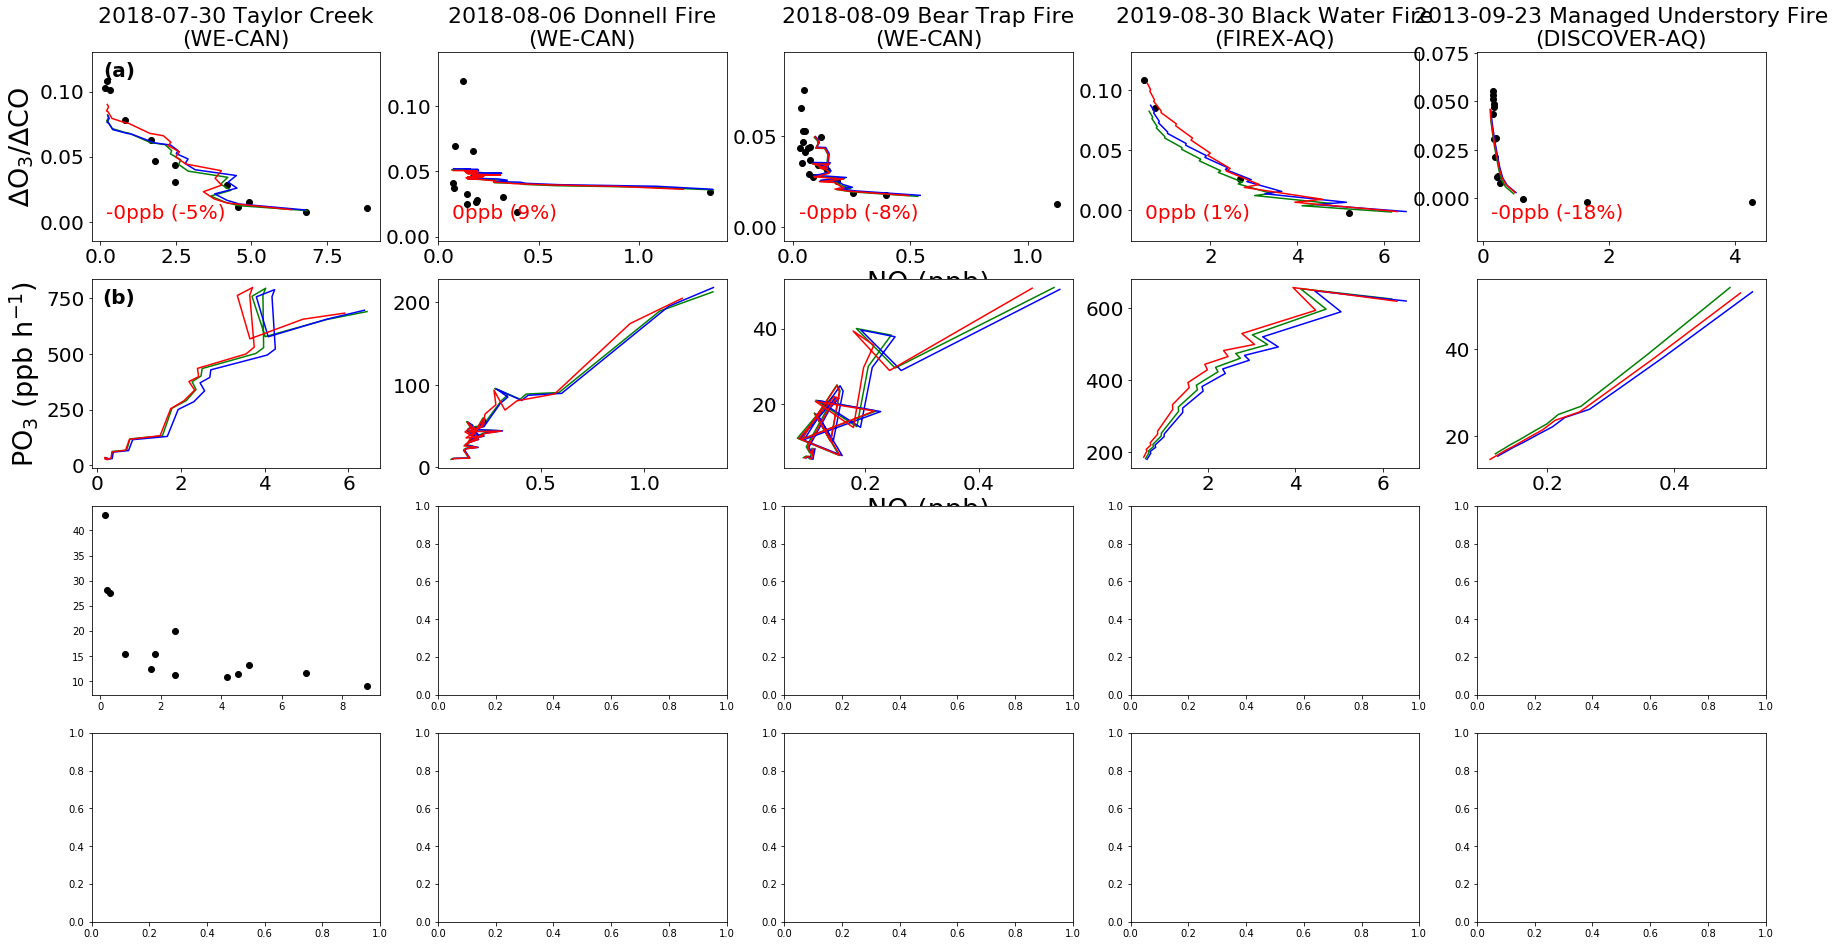

In [8]:
# Read compounds and each flight dataframe
Flight_IDs = ['RF03', 'RF07', 'RF09', 'FN19', 'P-3B']

# Define the subplot labels
subplot_labels = ['(a)', '(b)', '(c)', '(d)', 
                  '(e)', '(f)', '(g)', '(h)', 
                  '(i)', '(j)', '(k)']


# Different targets for each row
targets = [
    ('NEMR(O3)', 'NO', 'smk'),
    ('PO3', 'NO', 'smk'),
    ('OHRvoc vs OHRnox', 'NO', 'smk'),
    ('CH2O vs NO2', 'NO', 'smk'), 
]

# subplots: 4 rows (for each target combination) and 5 columns (for each Flight)
fig, axes = plt.subplots(len(targets), len(Flight_IDs), 
                         figsize=(6 * len(Flight_IDs), 4 * len(targets)),)
                         #sharex='col')

# Iterate over each row (target combination) and column (Flight ID)
for row, (target_y, target_x, postfix) in enumerate(targets):
    for col, Flight_ID in enumerate(Flight_IDs):
        #print(Flight_ID)
        # Set up the starting point
        # File directory, auto change for each flight ID
        if Flight_ID in ['RF03', 'RF07', 'RF09']:file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Dataprocess/analysis_bycompound/'
        if Flight_ID in ['FN19']: file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/FIREX-AQ/Dataprocess/analysis_bycompound/'
        if Flight_ID in ['P-3B']: file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/P-3B/Dataprocess/analysis_bycompound/'
        file_prefix_PL  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/PL_budget/output/'

        # --------------
        # Reading data
        # Set up x and y
        # --------------
        # ! Initial CO
        # Read CO smk data
        data_CO_smk_init = pd.read_csv(f'{file_prefix_conc}CO/{Flight_ID}_obs_smk.csv', index_col=0)['Observation'].iloc[0]
        # !! Observation
        df_obs_nemr_o3 = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_obs_nemr_ox = (pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_obs_smk_dil.csv', index_col=0) + pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_obs_smk_dil.csv', index_col=0)) / data_CO_smk_init
        df_obs_o3      = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_no      = pd.read_csv(f'{file_prefix_conc}NO/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_no2     = pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_nox     = pd.read_csv(f'{file_prefix_conc}NOx/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_pan     = pd.read_csv(f'{file_prefix_conc}PAN/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_ch2o    = pd.read_csv(f'{file_prefix_conc}Formaldehyde/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_obs_ch2o_no2=df_obs_ch2o.div(df_obs_no2)
        
        if target_y in ['TVOCR', 'OHRvoc vs OHRnox', 'OHRnox vs OHRvoc'] or target_x in ['TVOCR', 'OHRvoc vs OHRnox', 'OHRnox vs OHRvoc']:
            df_obs_vocr = VOCR_reader_cases(Flight_ID=Flight_ID, get_smk_dil=(postfix == 'smk_dil'), get_smk_conc=(postfix == 'smk'))
            df_obs_OHRnox        = (df_obs_no*9.7605E-12 + df_obs_no2*9.8258E-12)*2.46e10
            df_obs_OHRvoc_OHRnox = df_obs_vocr.div(df_obs_OHRnox)
            df_obs_OHRnox_OHRvoc = df_obs_OHRnox.div(df_obs_vocr)
        else: # speed up the code
            df_obs_vocr = [np.nan]*len(df_obs_o3)
            df_obs_OHRnox = [np.nan]*len(df_obs_o3)
            df_obs_OHRvoc_OHRnox = [np.nan]*len(df_obs_o3)
            df_obs_OHRnox_OHRvoc = [np.nan]*len(df_obs_o3)
        # !! Model
        df_mod_nemr_o3 = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_mod_nemr_ox = (pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_mod_smk_dil.csv', index_col=0) + pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_mod_smk_dil.csv', index_col=0)) / data_CO_smk_init
        df_mod_o3      = pd.read_csv(f'{file_prefix_conc}O3/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_no      = pd.read_csv(f'{file_prefix_conc}NO/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_no2     = pd.read_csv(f'{file_prefix_conc}NO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_nox     = pd.read_csv(f'{file_prefix_conc}NOx/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_pan     = pd.read_csv(f'{file_prefix_conc}PAN/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ch2o    = pd.read_csv(f'{file_prefix_conc}Formaldehyde/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ch2o_no2= df_mod_ch2o.div(df_mod_no2)
        df_mod_vocr    = pd.read_csv(f'{file_prefix_conc}TVOCR/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_OHRnox  = (df_mod_no*9.7605E-12 + df_mod_no2*9.8258E-12)*2.46e10
        df_mod_OHRvoc_OHRnox = df_mod_vocr.div(df_mod_OHRnox) 
        df_mod_OHRnox_OHRvoc = df_mod_OHRnox.div(df_mod_vocr) 
        df_mod_ho2 = pd.read_csv(f'{file_prefix_conc}HO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_ro2 = pd.read_csv(f'{file_prefix_conc}TRO2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        
        # !! Model results
        # L(ROx)/L(NOx_broad)
        df_mod_nox_broad_loss = pd.read_csv(f'{file_prefix_PL}NOx_broad/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)
        df_mod_rox_loss       = pd.read_csv(f'{file_prefix_PL}ROx/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)   
        df_mod_Lrox_Lnox_broad= df_mod_rox_loss.div(df_mod_nox_broad_loss)
        # Ln/Q
        df_mod_hno3_prod = pd.read_csv(f'{file_prefix_PL}HNO3/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
        df_mod_hno4_prod = pd.read_csv(f'{file_prefix_PL}HNO4/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
        df_mod_pns_prod  = pd.read_csv(f'{file_prefix_PL}PNs/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
        df_mod_ans_prod  = pd.read_csv(f'{file_prefix_PL}ANs/{Flight_ID}_Production_rates_evolution.csv', index_col=0)   
        df_mod_Ln    = -(df_mod_hno3_prod + df_mod_hno4_prod + df_mod_pns_prod + df_mod_ans_prod)
        #df_mod_Ln   = pd.read_csv(f'{file_prefix_PL}NOx/{Flight_ID}_Loss_rates.csv', index_col=0)   
        df_mod_Q     = df_mod_Ln + df_mod_rox_loss
        df_mod_Ln_Q  = df_mod_Ln.div(df_mod_Q)

        # H2O2/HNO3
        df_mod_h2o2      = pd.read_csv(f'{file_prefix_conc}H2O2/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_hno3      = pd.read_csv(f'{file_prefix_conc}HNO3/{Flight_ID}_mod_{postfix}.csv', index_col=0)
        df_mod_h2o2_hno3 = df_mod_h2o2.div(df_mod_hno3)
        
        # OPE
        df_mod_o3_prod    = pd.read_csv(f'{file_prefix_PL}O3/{Flight_ID}_Production_rates_evolution.csv', index_col=0)
        df_mod_ox_prod    = pd.read_csv(f'{file_prefix_PL}Ox/{Flight_ID}_Production_rates_evolution.csv', index_col=0)
        df_mod_ox_loss    = pd.read_csv(f'{file_prefix_PL}Ox/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)
        df_mod_ox_netprod = df_mod_ox_prod + df_mod_ox_loss
        df_mod_nox_loss   = pd.read_csv(f'{file_prefix_PL}NOx/{Flight_ID}_Loss_rates_evolution.csv', index_col=0)   

        # OH evaluation
        # observation and model for OH or chemical age
        df_obs_cal_OH, df_mod_cal_OH, df_mod_ = calculate_oh_chem_age_stats(voc_names, file_prefix_conc, Flight_ID, 0)    
        # make df_obs_cal_OH as a dataframe with observation...
        df_obs_cal_OH = pd.DataFrame(df_obs_cal_OH['Median']).rename(columns={'Median': 'Observation'})

        # Get chemical age
        df_obs_cal_chem_age, df_mod_cal_chem_age, df_mod_output_chem_age = calculate_oh_chem_age_stats(voc_names, file_prefix_conc, Flight_ID, 1)    
        # make df_obs_cal_OH as a dataframe with observation...
        df_obs_cal_chem_age = pd.DataFrame(df_obs_cal_chem_age['Median']).rename(columns={'Median': 'Observation'})

        # ---------------------
        # Data processing
        # standardize, bin time
        # ---------------------
        standard_index = df_mod_o3_prod.index.values if target_y in ['PO3', 'POx', 'net POx', 'OPE', 'Ln', 'LROx', 'Ln vs Q', 'LROx vs LNOx_broad'] else df_mod_o3.index.values    
        # Concentration
        df_mod_o3_interp            = interp(df_mod_o3, standard_index)
        df_mod_nemr_o3_interp       = interp(df_mod_nemr_o3, standard_index)
        df_mod_nemr_ox_interp       = interp(df_mod_nemr_ox, standard_index)
        df_mod_no_interp            = interp(df_mod_no, standard_index)
        df_mod_no2_interp           = interp(df_mod_no2, standard_index)
        df_mod_nox_interp           = interp(df_mod_nox, standard_index)
        df_mod_pan_interp           = interp(df_mod_pan, standard_index)
        df_mod_ch2o_interp          = interp(df_mod_ch2o, standard_index)
        df_mod_ch2o_no2_interp      = interp(df_mod_ch2o_no2, standard_index)
        df_mod_vocr_interp          = interp(df_mod_vocr, standard_index)
        df_mod_OHRnox_interp        = interp(df_mod_OHRnox, standard_index)
        df_mod_OHRvoc_OHRnox_interp = interp(df_mod_OHRvoc_OHRnox, standard_index)
        df_mod_OHRnox_OHRvoc_interp = interp(df_mod_OHRnox_OHRvoc, standard_index)
        df_mod_cal_OH_interp         = interp(df_mod_cal_OH, standard_index)
        #df_mod_output_OH_interp      = interp(df_mod_output_OH, standard_index)
        df_mod_cal_chem_age_interp   = interp(df_mod_cal_chem_age, standard_index)
        df_mod_output_chem_age_interp= interp(df_mod_output_chem_age, standard_index)

        df_mod_ho2_interp           = interp(df_mod_ho2, standard_index)
        df_mod_ro2_interp           = interp(df_mod_ro2, standard_index)
        # L(ROx)/L(NOx_broad)
        df_mod_nox_broad_loss_interp = interp(df_mod_nox_broad_loss, standard_index)
        df_mod_rox_loss_interp       = interp(df_mod_rox_loss, standard_index)
        df_mod_Lrox_Lnox_broad_interp= interp(df_mod_Lrox_Lnox_broad, standard_index)
        # Ln/Q
        df_mod_Ln_interp             = interp(df_mod_Ln, standard_index)
        df_mod_Q_interp              = interp(df_mod_Q, standard_index)
        df_mod_Ln_Q_interp           = interp(df_mod_Ln_Q, standard_index)

        # H2O2/HNO3
        df_mod_h2o2_interp           = interp(df_mod_h2o2, standard_index)
        df_mod_hno3_interp           = interp(df_mod_hno3, standard_index)
        df_mod_h2o2_hno3_interp      = interp(df_mod_h2o2_hno3, standard_index)
        
        # OPE
        df_mod_o3_prod_interp        = interp(df_mod_o3_prod, standard_index)
        df_mod_ox_prod_interp        = interp(df_mod_ox_prod, standard_index)
        df_mod_ox_netprod_interp     = interp(df_mod_ox_netprod, standard_index)
        df_mod_nox_loss_interp       = interp(df_mod_nox_loss, standard_index)

        # ------------
        # Bin the data
        # ------------
        if 'RF' not in Flight_ID: interval = 5
        if Flight_ID == 'RF03': interval = 5
        if Flight_ID == 'RF07': interval = 5
        if Flight_ID == 'RF09': interval = 10
        df_mod_o3_bin     = bin_df(df_mod_o3_interp,interval).iloc[1:]
        df_mod_nemr_o3_bin= bin_df(df_mod_nemr_o3_interp,interval).iloc[1:]
        df_mod_nemr_ox_bin= bin_df(df_mod_nemr_ox_interp,interval).iloc[1:]
        df_mod_no_bin     = bin_df(df_mod_no_interp,interval).iloc[1:]
        df_mod_no2_bin    = bin_df(df_mod_no2_interp,interval).iloc[1:]
        df_mod_nox_bin    = bin_df(df_mod_nox_interp,interval).iloc[1:]
        df_mod_pan_bin    = bin_df(df_mod_pan_interp,interval).iloc[1:]
        df_mod_ch2o_bin   = bin_df(df_mod_ch2o_interp,interval).iloc[1:]
        df_mod_ch2o_no2_bin= bin_df(df_mod_ch2o_no2_interp,interval).iloc[1:]
        df_mod_vocr_bin   = bin_df(df_mod_vocr_interp,interval).iloc[1:]
        df_mod_OHRnox_bin = bin_df(df_mod_OHRnox_interp,interval).iloc[1:]
        df_mod_OHRvoc_OHRnox_bin = bin_df(df_mod_OHRvoc_OHRnox_interp,interval).iloc[1:]
        df_mod_OHRnox_OHRvoc_bin = bin_df(df_mod_OHRnox_OHRvoc_interp,interval).iloc[1:]
        #df_mod_output_OH_bin      = bin_df(df_mod_output_OH_interp, interval).iloc[1:]
        df_mod_output_chem_age_bin= bin_df(df_mod_output_chem_age_interp, interval).iloc[1:]
        df_mod_ho2_bin      = bin_df(df_mod_ho2_interp, interval).iloc[1:]
        df_mod_ro2_bin      = bin_df(df_mod_ro2_interp, interval).iloc[1:]

        # Special implementation for calculated OH/chemical age. The VOCs selected in this case is not in the CTMs thus we have to assume all experients shared the same calculated values
        # Make the Chemical age bin the same pattern as other simulations
        df_mod_cal_OH_bin_dummy  = bin_df(df_mod_cal_OH_interp, interval).iloc[1:] # this is only application for MCMBBVOC
        df_mod_cal_chem_age_bin_dummy  = bin_df(df_mod_cal_chem_age_interp, interval).iloc[1:] # this is only application for MCMBBVOC
        dummy_cols = ['GEOS-Chem (base)', 'GEOS-Chem + FUR', 'MCM + FUR', 'MCM + GEOS-Chem VOCs']
        # Create a new DataFrame with repeated median and IQR values across specified columns
        df_mod_cal_chem_age_bin = pd.DataFrame(index=df_mod_cal_chem_age_bin_dummy.index, columns=pd.MultiIndex.from_product([dummy_cols, ['median', 'iqr']]))
        df_mod_cal_OH_bin = pd.DataFrame(index=df_mod_cal_OH_bin_dummy.index, columns=pd.MultiIndex.from_product([dummy_cols, ['median', 'iqr']]))
        for column in dummy_cols:
            df_mod_cal_chem_age_bin[(column, 'median')], df_mod_cal_chem_age_bin[(column, 'iqr')] = df_mod_cal_chem_age_bin_dummy['Median', 'median'], df_mod_cal_chem_age_bin_dummy['Median', 'iqr']
            df_mod_cal_OH_bin[(column, 'median')], df_mod_cal_OH_bin[(column, 'iqr')] = df_mod_cal_OH_bin_dummy['Median', 'median'], df_mod_cal_OH_bin_dummy['Median', 'iqr']

        # L(ROx)/L(NOx_broad)
        df_mod_nox_broad_loss_bin = bin_df(df_mod_nox_broad_loss, interval).iloc[1:]
        df_mod_rox_loss_bin       = bin_df(df_mod_rox_loss, interval).iloc[1:]
        df_mod_Lrox_Lnox_broad_bin= bin_df(df_mod_Lrox_Lnox_broad, interval).iloc[1:]
        # H2O2/HNO3
        df_mod_h2o2_bin           = bin_df(df_mod_h2o2, interval).iloc[1:]
        df_mod_hno3_bin           = bin_df(df_mod_hno3, interval).iloc[1:]
        df_mod_h2o2_hno3_bin      = bin_df(df_mod_h2o2_hno3, interval).iloc[1:]        
        # Ln/Q
        df_mod_Ln_bin             = bin_df(df_mod_Ln, interval).iloc[1:]
        df_mod_Q_bin              = bin_df(df_mod_Q, interval).iloc[1:]
        df_mod_Ln_Q_bin           = bin_df(df_mod_Ln_Q, interval).iloc[1:]
        # OPE
        df_mod_o3_prod_bin        = bin_df(df_mod_o3_prod, interval).iloc[1:]
        df_mod_ox_prod_bin        = bin_df(df_mod_ox_prod, interval).iloc[1:]
        df_mod_ox_netprod_bin     = bin_df(df_mod_ox_netprod, interval).iloc[1:]
        df_mod_nox_loss_bin       = bin_df(df_mod_nox_loss, interval).iloc[1:]
        # --------------------
        # Select targt x and y
        # --------------------
        # Dictionary mapping targets to their corresponding dataframes
        dataframes_mapping = {
            'NO':              (df_obs_no, df_mod_no_bin),
            'NO2':             (df_obs_no2, df_mod_no2_bin),
            'NOx':             (df_obs_nox, df_mod_nox_bin),
            'PAN':             (df_obs_pan, df_mod_pan_bin),
            'CH2O':            (df_obs_ch2o, df_mod_ch2o_bin),
            'CH2O vs NO2':     (df_obs_ch2o_no2, df_mod_ch2o_no2_bin),
            'TVOCR':           (df_obs_vocr, df_mod_vocr_bin),
            'Ozone':           (df_obs_o3, df_mod_o3_bin),
            'NEMR(O3)':        (df_obs_nemr_o3, df_mod_nemr_o3_bin),
            'NEMR(Ox)':        (df_obs_nemr_ox, df_mod_nemr_ox_bin),
            'OHRnox':          (df_obs_OHRnox, df_mod_OHRnox_bin),
            'OHRvoc vs OHRnox':(df_obs_OHRvoc_OHRnox, df_mod_OHRvoc_OHRnox_bin),
            'OHRnox vs OHRvoc':(df_obs_OHRnox_OHRvoc, df_mod_OHRnox_OHRvoc_bin),
            'Physical age':    (df_obs_o3.assign(Observation=df_obs_o3.index)/60,
                                df_mod_o3_bin.apply(lambda col_test: df_mod_o3_bin.index if 'median' in col_test.name else 0, axis=0)/60),
            'Chemical age':      (df_obs_cal_chem_age, df_mod_cal_chem_age_bin), 
            #'OH analysis':       (df_obs_cal_OH, df_mod_output_OH_bin), # !!! This is specailly set and can be modified for own purpose!!!
            'LROx':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_rox_loss_bin),
            'LNOx_broad':        (df_obs_o3.applymap(lambda x: np.nan), df_mod_nox_broad_loss_bin),
            'LROx vs LNOx_broad':(df_obs_o3.applymap(lambda x: np.nan), df_mod_Lrox_Lnox_broad_bin),
            'H2O2':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_h2o2_bin),
            'HNO3':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_hno3_bin),
            'H2O2 vs HNO3':      (df_obs_o3.applymap(lambda x: np.nan), df_mod_h2o2_hno3_bin),
            'Ln':                (df_obs_o3.applymap(lambda x: np.nan), df_mod_Ln_bin),
            'Q':                 (df_obs_o3.applymap(lambda x: np.nan), df_mod_Q_bin),
            'Ln vs Q':           (df_obs_o3.applymap(lambda x: np.nan), df_mod_Ln_Q_bin),
            'PO3':               (df_obs_o3.applymap(lambda x: np.nan), df_mod_o3_prod_bin),
            'POx':               (df_obs_o3.applymap(lambda x: np.nan), df_mod_ox_prod_bin),
            'net POx':           (df_obs_o3.applymap(lambda x: np.nan), df_mod_ox_netprod_bin),
            'LNOx':              (df_obs_o3.applymap(lambda x: np.nan), df_mod_nox_loss_bin),
        }

        # Select target x and y
        df_x_obs, df_x_mod = dataframes_mapping.get(target_x, (None, None))
        df_y_obs, df_y_mod = dataframes_mapping.get(target_y, (None, None))
        # Replace the 0 as nan in the observation data
        df_x_obs['Observation'] = df_x_obs['Observation'].replace(0, np.nan)
        df_y_obs['Observation'] = df_y_obs['Observation'].replace(0, np.nan)
        # --------
        # Plotting
        # --------
        # Observations
        if not ((df_x_obs['Observation'].eq(0)).all()) and \
            not (df_x_obs['Observation'].isna().all()) and \
            not ((df_x_obs['Observation'].eq(0)).all()) and \
            not (df_y_obs['Observation'].isna().all()):
            axes[row, col].scatter(df_x_obs['Observation'], df_y_obs['Observation'], 
                              label = 'Obs', color = 'black')
        # Model results
        axes[row, col].plot(df_x_mod['GEOS-Chem (base)', 'median'].tolist(), df_y_mod['GEOS-Chem (base)', 'median'],
                       color=colors[0], label='$GC$')#, marker='o')  # Line plot with markers
        axes[row, col].plot(df_x_mod['MCM + GEOS-Chem VOCs', 'median'].tolist(), df_y_mod['MCM + GEOS-Chem VOCs', 'median'],
                       color=colors[3], label='$MCM_{GCVOC}$')#, marker='o')  # Line plot with markers
        axes[row, col].plot(df_x_mod['MCM + FUR', 'median'].tolist(), df_y_mod['MCM + FUR', 'median'],
                       color=colors[2], label='$MCM_{BBVOC}$')#, marker='o')  # Line plot with marker

        # Add a horizontal line at y = 0.5 to the axes
        if (target_y, target_x) == ('LROx vs LNOx_broad', 'Physical age') : axes[row, col].axhline(y=1, color='black', linestyle='-')    
        if (target_y, target_x) == ('Ln vs Q', 'Physical age') : axes[row, col].axhline(y=0.5, color='black', linestyle='-')    
        if (target_y, target_x) == ('OHRnox vs OHRvoc', 'Physical age') :
            if Flight_ID in ['RF03', 'FN19']: axes[row, col].axhline(y=0.2, color='black', linestyle='-')    
            axes[row, col].axhline(y=0.01, color='black', linestyle='-')    
        if (target_y, target_x) == ('CH2O vs NO2', 'Physical age') : 
            axes[row, col].axhline(y=2, color='black', linestyle='-')    
            axes[row, col].axhline(y=1, color='black', linestyle='-')    
        if (target_y, target_x) == ('H2O2 vs HNO3', 'Physical age') : 
            axes[row, col].axhline(y=0.4, color='black', linestyle='-')    
        
        # start from 0
        #axes[row, col].set_ylim(bottom=0)
        # ----------------------------------
        # Texts for slope and R square value
        # ---------------------------------
        # set up the row
        if row==0: axes[row, col].set_title(id2fire_name[Flight_ID], loc ='center', size=fontsize_flight*1.1)
        

        axes[row, col].tick_params(axis='both', labelsize=fontsize_tick)

        # Format y-axis tick labels to two decimal places
        #if target_y == 'NEMR(O3)': axes[row, col].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        axes[row, col].yaxis.set_major_formatter(mticker.ScalarFormatter())
        # Set x-axis ticks and labels with an interval of 0.5
        
        # Start with the default tick positions
        if target_x == 'Physical age':
            if Flight_ID == 'RF03': new_ticks = np.arange(0, 2.5 + 0.5, 0.5)
            if Flight_ID == 'RF07': new_ticks = np.arange(2, 5.5 + 0.5, 0.5)
            if Flight_ID == 'RF09': new_ticks = np.arange(0, 5.0 + 0.5, 0.5)
            if Flight_ID == 'FN19': new_ticks = np.arange(0, 1.5 + 0.5, 0.5)
            if Flight_ID == 'P-3B': new_ticks = np.arange(0, 1.0 + 0.5, 0.5)
            axes[row, col].set_xticks(new_ticks)
            axes[row, col].set_xticklabels([f"{tick:.1f}" for tick in new_ticks], rotation=30)
            # Set the x-axis limits
            axes[row, col].set_xlim([min(new_ticks), max(new_ticks)])

        # -------------------------------------
        # Calculate the model: observation bias
        # -------------------------------------
        if not ((df_x_obs['Observation'].eq(0)).all()) and \
            not (df_x_obs['Observation'].isna().all()) and \
            not ((df_x_obs['Observation'].eq(0)).all()) and \
            not (df_y_obs['Observation'].isna().all()):
            # Polinomial regression line
            # train the model based on observation data
            idx = np.isfinite(df_x_obs['Observation']) & np.isfinite(df_y_obs['Observation'])         # only pass datapoint with values
            coefs = np.polyfit(df_x_obs['Observation'][idx], df_y_obs['Observation'][idx], 2) # 3 may be the best fit
            poly_model = np.poly1d(coefs)
            # text for observations
            relative_diff1 = (df_y_mod['GEOS-Chem (base)', 'median']-poly_model(df_x_mod['GEOS-Chem (base)', 'median']))/poly_model(df_x_mod['GEOS-Chem (base)', 'median']) * 100       
            relative_diff1 = relative_diff1
            abs_diff1 = df_y_mod['GEOS-Chem (base)', 'median']-poly_model(df_x_mod['GEOS-Chem (base)', 'median'])

            relative_diff3 = (df_y_mod['MCM + GEOS-Chem VOCs', 'median']-poly_model(df_x_mod['MCM + GEOS-Chem VOCs', 'median']))/poly_model(df_x_mod['MCM + GEOS-Chem VOCs', 'median']) * 100       
            relative_diff3 = relative_diff3
            abs_diff3 = df_y_mod['MCM + GEOS-Chem VOCs', 'median']-poly_model(df_x_mod['MCM + GEOS-Chem VOCs', 'median'])

            relative_diff4 = (df_y_mod['MCM + FUR', 'median']-poly_model(df_x_mod['MCM + FUR', 'median']))/poly_model(df_x_mod['MCM + FUR', 'median']) * 100   
            relative_diff4 = relative_diff4 
            abs_diff4 = df_y_mod['MCM + FUR', 'median']-poly_model(df_x_mod['MCM + FUR', 'median'])

            # median of the diff
            relative_diff1 = np.nanmedian(relative_diff1)
            relative_diff3 = np.nanmedian(relative_diff3)
            relative_diff4 = np.nanmedian(relative_diff4)
            abs_diff1 = np.nanmedian(abs_diff1)
            abs_diff3 = np.nanmedian(abs_diff3)
            abs_diff4 = np.nanmedian(abs_diff4)

            # last data point of the diff
            diff_str1   = '{:.0f}'.format(abs_diff1) + 'ppb (' + '{:.0f}'.format(relative_diff1) +'%)'
            diff_str3   = '{:.0f}'.format(abs_diff3) + 'ppb (' + '{:.0f}'.format(relative_diff3) +'%)'
            diff_str4   = '{:.0f}'.format(abs_diff4) + 'ppb (' + '{:.0f}'.format(relative_diff4) +'%)'

            # Texts
            # get the range for the x/y axis
            xmin, xmax = axes[row, col].get_xlim()
            ymin, ymax = axes[row, col].get_ylim()
            if target_x in Comps_in_GC and target_y in Comps_in_GC:
                axes[row, col].text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.32+ymin, diff_str1, fontsize=fontsize_tick, color = colors[0])  
                axes[row, col].text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.22+ymin, diff_str3, fontsize=fontsize_tick, color = colors[3])  
            axes[row, col].text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.12+ymin, diff_str4, fontsize=fontsize_tick, color = colors[2])
        
    # Add y-axis labels for each row
    axes[row, 0].set_ylabel(text_labels.get(target_y, target_y), fontsize=fontsize_comp*1.5)
    
    axes[row, 2].set_xlabel(text_labels.get(target_x, target_x), fontsize=fontsize_comp*1.5)
    fig.align_ylabels(axes[row, :])  # Align y-labels for each row
    
    # Add subplot labels for the first column of each row
    axes[row, 0].text(0.15, 0.95, subplot_labels[row], 
                      transform=axes[row, 0].transAxes, 
                      fontsize=20, fontweight='bold', va='top', ha='right')

# Adjust subplot layout
#plt.subplots_adjust(wspace=0.2, hspace=0.05)


# Set figure title
#fig.suptitle('Figure Title', fontsize=35)

plt.tight_layout()
plt.show()

CH2O:NO2 vs TVOC might be a good way to test.

In [23]:
df_met_obs.columns

Index(['PRESSURE', 'TEMPERATURE', 'RHUM', 'SZA', 'JNO2_NO_O3P', 'JHNO2_OH_NO',
       'JH2O2_2OH', 'JHNO3_OH_NO2', 'JO3_O2_O1D', 'JCH2O_H_HCO', 'JCH2O_H2_CO',
       'JNO3_NO_O2', 'JNO3_NO2_O3P', 'JN2O5_NO3_NO2',
       'JHNO4_HO2_NO2_UV_VISonly', 'JCH3CHO_CH3_HCO', 'JPropanal_C2H5_HCO',
       'JCH3OOH_CH3O_OH', 'JMeONO2_CH3O_NO2', 'JEthONO2_CH3CH2O_NO2',
       'JCH3COOONO2_CH3COOO_NO2', 'JCH3COOONO2_CH3COO_NO3', 'JMAC_Products',
       'JMVK_Products', 'JAcetone_CH3CO_CH3', 'JMEK_CH3CO_CH2CH3',
       'JHydroxyacetone_CH3COO_CH3', 'JHydroxyacetone_CH3CO_CH3O',
       'JCHOCHO_HCO_HCO', 'JCHOCHO_H2_2CO', 'JCHOCHO_CH2O_CO',
       'JCH3COCHO_CH3CO_HCO', 'J23Butanedione_Products', 'JCl2_Cl_Cl',
       'JClO_Cl_O3P', 'JClNO2_Cl_NO2', 'JClONO_Cl_NO2', 'JClONO2_Cl_NO3',
       'JClONO2_ClO_NO2', 'JBr2_Br_Br', 'JBrO_Br_O', 'JHOBr_OH_Br',
       'JBrNO_Br_NO', 'JBrONO_Br_NO2', 'JBrONO_BrO_NO', 'JBrNO2_Br_NO2',
       'JBrONO2_BrO_NO2', 'JBrONO2_Br_NO3', 'JBrCl_Br_Cl', 'JCHBr3_Products',
   

#### Averaged HOx production budget

Text(0.52, 0.98, 'Averaged HO${_x}$ production budget')

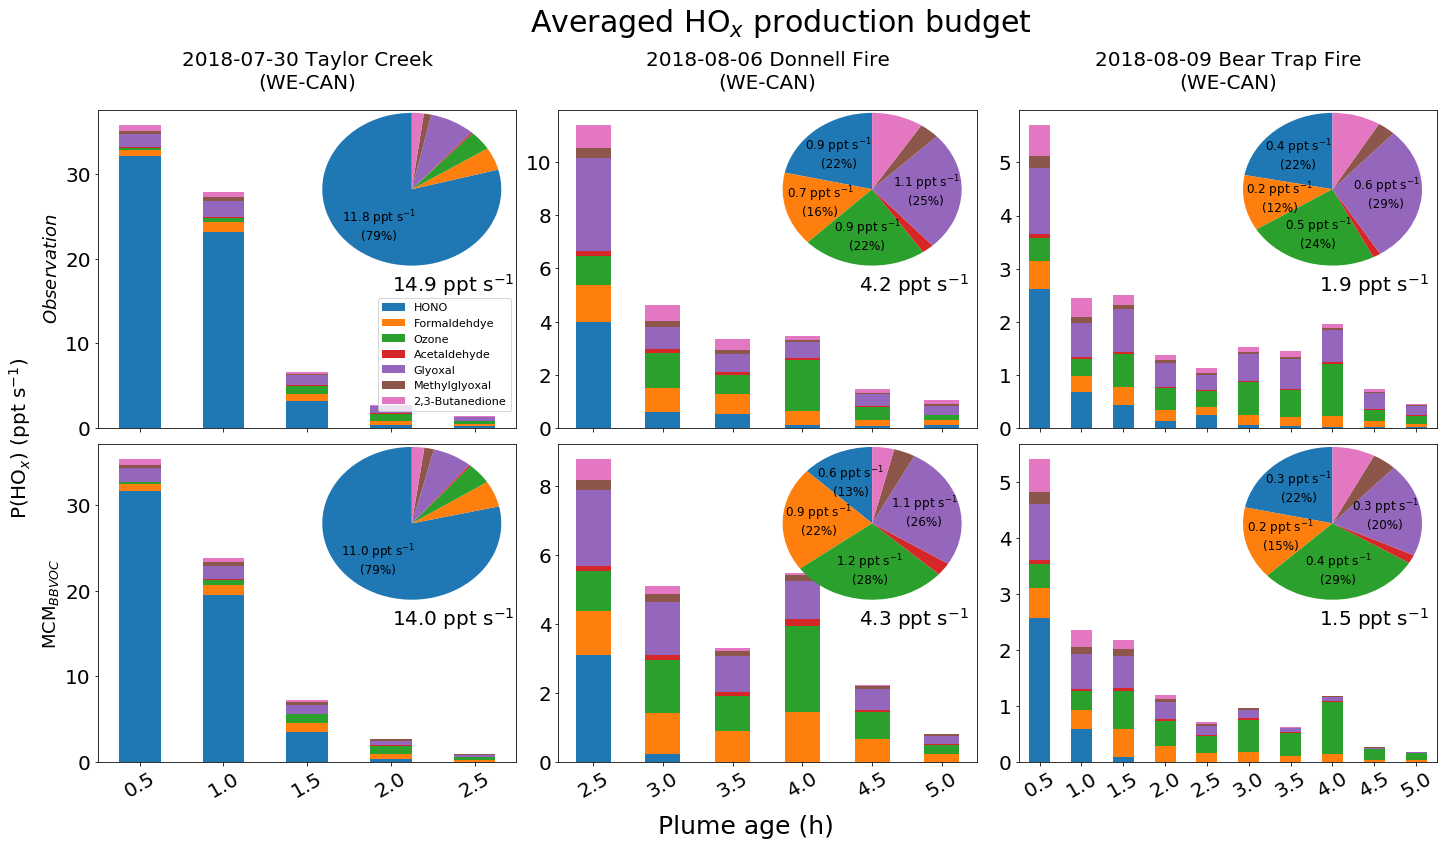

In [21]:

# setting for smk or bkg
get_smk, get_smk_dil, get_smk_conorm = True, False, False
#get_smk, get_smk_dil, get_smk_conorm = False, True, False
#get_smk, get_smk_dil, get_smk_conorm = False, False, True
# setting up postfic name
if get_smk:         postfix = 'smk'
if get_smk_dil:     postfix = 'smk_dil'
if get_smk_conorm:  postfix = 'smk_conorm'


# Read compounds and each flight dataframe
Flight_IDs   = ['RF03', 'RF07', 'RF09', 'FN19','P-3B']
Flight_IDs   = ['RF03', 'RF07', 'RF09']


# plotting for the figure
linewidth = 3
fontsize_flight = 20
fontsize_tick   = 20
fontsize_label  = 12
fontsize_comp   = 18

# colors for model
colors = ['green', 'purple', 'orange', \
          'red', 'blue']

# Customized
num_rows = 2

# subplots 
fig, axes = plt.subplots(num_rows, len(Flight_IDs), 
                         figsize=(8*len(Flight_IDs), 6*num_rows),
                         sharex='col')
for col, Flight_ID in enumerate(Flight_IDs):
    # ---------
    # Read data
    # ---------
    if Flight_ID in ['RF03', 'RF07', 'RF09']: 
        file_prefix  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Dataprocess/analysis_bycompound/'
    if Flight_ID in ['FN19']: 
        file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/FIREX-AQ/Dataprocess/analysis_bycompound/'
    if Flight_ID in ['P-3B']: 
        file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/P-3B/Dataprocess/analysis_bycompound/'    
    # Met data
    df_met_obs = pd.read_csv(f'/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Model_inputs_prepared/output_data/{Flight_ID}_met_data.csv')
    df_met_obs = df_met_obs.set_index('Age_physical_avg_min')
    df_met_obs.index = pd.Series(df_met_obs.index).round(2)

    if Flight_ID == 'RF03': df_met_obs = df_met_obs.iloc[1:] 
    # Compound concentration
    df_voc_obs_hno2    = pd.read_csv(f'{file_prefix}HONO/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_voc_obs_ch2o    = pd.read_csv(f'{file_prefix}Formaldehyde/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_voc_obs_ald2    = pd.read_csv(f'{file_prefix}Acetaldehyde/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_voc_obs_o3      = pd.read_csv(f'{file_prefix}O3/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_voc_obs_glyx    = pd.read_csv(f'{file_prefix}Glyoxal/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_voc_obs_mgly    = pd.read_csv(f'{file_prefix}Methylglyoxal/{Flight_ID}_obs_{postfix}.csv', index_col=0)
    df_voc_obs_biacet  = pd.read_csv(f'{file_prefix}Butanedione/{Flight_ID}_obs_{postfix}.csv', index_col=0)

    if Flight_ID == 'RF03':
        df_voc_obs_hno2 = df_voc_obs_hno2.iloc[1:]
        df_voc_obs_ch2o = df_voc_obs_ch2o.iloc[1:]
        df_voc_obs_ald2 = df_voc_obs_ald2.iloc[1:]
        df_voc_obs_o3   = df_voc_obs_o3.iloc[1:]
        df_voc_obs_glyx = df_voc_obs_glyx.iloc[1:]
        df_voc_obs_mgly = df_voc_obs_mgly.iloc[1:]
        df_voc_obs_biacet = df_voc_obs_biacet.iloc[1:]
    
    df_voc_mod_hno2    = pd.read_csv(f'{file_prefix}HONO/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_voc_mod_ch2o    = pd.read_csv(f'{file_prefix}Formaldehyde/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_voc_mod_ald2    = pd.read_csv(f'{file_prefix}Acetaldehyde/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_voc_mod_o3      = pd.read_csv(f'{file_prefix}O3/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_voc_mod_glyx    = pd.read_csv(f'{file_prefix}Glyoxal/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_voc_mod_mgly    = pd.read_csv(f'{file_prefix}Methylglyoxal/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_voc_mod_biacet  = pd.read_csv(f'{file_prefix}Butanedione/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    # ----------------------------
    # Bin the concentration first
    # ----------------------------
    # Create bin edges for every X minutes
    # This is only applied to model
    interval_X = 30
    # Observation
    binned_obs_stats_met    = bin_df(df_met_obs, interval_X)
    binned_obs_stats_hno2   = bin_df(df_voc_obs_hno2, interval_X)
    binned_obs_stats_ch2o   = bin_df(df_voc_obs_ch2o, interval_X)
    binned_obs_stats_ald2   = bin_df(df_voc_obs_ald2, interval_X)
    binned_obs_stats_o3     = bin_df(df_voc_obs_o3, interval_X)
    binned_obs_stats_glyx   = bin_df(df_voc_obs_glyx, interval_X)
    binned_obs_stats_mgly   = bin_df(df_voc_obs_mgly, interval_X)
    binned_obs_stats_biacet = bin_df(df_voc_obs_biacet, interval_X)
    
    binned_mod_stats_hno2   = bin_df(df_voc_mod_hno2, interval_X)  
    binned_mod_stats_ch2o   = bin_df(df_voc_mod_ch2o, interval_X)
    binned_mod_stats_ald2   = bin_df(df_voc_mod_ald2, interval_X)
    binned_mod_stats_o3     = bin_df(df_voc_mod_o3, interval_X)
    binned_mod_stats_glyx   = bin_df(df_voc_mod_glyx, interval_X)
    binned_mod_stats_mgly   = bin_df(df_voc_mod_mgly, interval_X)
    binned_mod_stats_biacet = bin_df(df_voc_mod_biacet, interval_X)

    # -----------------------------
    # Calculation of HOx production
    # -----------------------------
    # observation
    df_obs_hno2 = binned_obs_stats_hno2['Observation', 'mean'].mul(binned_obs_stats_met['JHNO2_OH_NO', 'mean'].values, axis=0)
    df_obs_ch2o = binned_obs_stats_ch2o['Observation', 'mean'].mul(binned_obs_stats_met['JCH2O_H_HCO', 'mean'].values, axis=0)
    df_obs_ald2 = binned_obs_stats_ald2['Observation', 'mean'].mul(binned_obs_stats_met['JCH3CHO_CH3_HCO', 'mean'].values, axis=0)
    df_obs_o3   = 0.5*binned_obs_stats_o3['Observation', 'mean'].mul(binned_obs_stats_met['JO3_O2_O1D', 'mean'].values, axis=0)
    df_obs_glyx = 2*binned_obs_stats_glyx['Observation', 'mean'].mul(binned_obs_stats_met['JCHOCHO_HCO_HCO', 'mean'].values, axis=0)
    df_obs_mgly = 1.3*binned_obs_stats_mgly['Observation', 'mean'].mul(binned_obs_stats_met['JCH3COCHO_CH3CO_HCO', 'mean'].values, axis=0)
    df_obs_biacet = 0.6*binned_obs_stats_biacet['Observation', 'mean'].mul(binned_obs_stats_met['J23Butanedione_Products', 'mean'].values, axis=0)

    # mod
    df_mod_hno2_MCMBBVOC   = binned_mod_stats_hno2['MCM + FUR', 'mean'].mul(binned_obs_stats_met['JHNO2_OH_NO', 'mean'], axis=0)
    df_mod_ch2o_MCMBBVOC   = binned_mod_stats_ch2o['MCM + FUR', 'mean'].mul(binned_obs_stats_met['JCH2O_H_HCO', 'mean'], axis=0)
    df_mod_ald2_MCMBBVOC   = binned_mod_stats_ald2['MCM + FUR', 'mean'].mul(binned_obs_stats_met['JCH3CHO_CH3_HCO', 'mean'], axis=0)
    df_mod_o3_MCMBBVOC     = 0.5*binned_mod_stats_o3['MCM + FUR', 'mean'].mul(binned_obs_stats_met['JO3_O2_O1D', 'mean'], axis=0)
    df_mod_glyx_MCMBBVOC   = 2*binned_mod_stats_glyx['MCM + FUR', 'mean'].mul(binned_obs_stats_met['JCHOCHO_HCO_HCO', 'mean'], axis=0)
    df_mod_mgly_MCMBBVOC   = 1.3*binned_mod_stats_mgly['MCM + FUR', 'mean'].mul(binned_obs_stats_met['JCH3COCHO_CH3CO_HCO', 'mean'], axis=0)
    df_mod_biacet_MCMBBVOC = 0.6*binned_mod_stats_biacet['MCM + FUR', 'mean'].mul(binned_obs_stats_met['J23Butanedione_Products', 'mean'], axis=0)

    df_mod_hno2_GC   = binned_mod_stats_hno2['GEOS-Chem (base)', 'mean'].mul(binned_obs_stats_met['JHNO2_OH_NO', 'mean'], axis=0)
    df_mod_ch2o_GC   = binned_mod_stats_ch2o['GEOS-Chem (base)', 'mean'].mul(binned_obs_stats_met['JCH2O_H_HCO', 'mean'], axis=0)
    df_mod_ald2_GC   = binned_mod_stats_ald2['GEOS-Chem (base)', 'mean'].mul(binned_obs_stats_met['JCH3CHO_CH3_HCO', 'mean'], axis=0)
    df_mod_o3_GC     = 0.5*binned_mod_stats_o3['GEOS-Chem (base)', 'mean'].mul(binned_obs_stats_met['JO3_O2_O1D', 'mean'], axis=0)
    df_mod_glyx_GC   = 2*binned_mod_stats_glyx['GEOS-Chem (base)', 'mean'].mul(binned_obs_stats_met['JCHOCHO_HCO_HCO', 'mean'], axis=0)
    df_mod_mgly_GC   = 1.3*binned_mod_stats_mgly['GEOS-Chem (base)', 'mean'].mul(binned_obs_stats_met['JCH3COCHO_CH3CO_HCO', 'mean'], axis=0)
    df_mod_biacet_GC = 0.6*binned_mod_stats_biacet['GEOS-Chem (base)', 'mean'].mul(binned_obs_stats_met['J23Butanedione_Products', 'mean'], axis=0)
    
    df_mod_hno2_MCMGCVOC = binned_mod_stats_hno2['MCM + GEOS-Chem VOCs', 'mean'].mul(binned_obs_stats_met['JHNO2_OH_NO', 'mean'], axis=0)
    df_mod_ch2o_MCMGCVOC = binned_mod_stats_ch2o['MCM + GEOS-Chem VOCs', 'mean'].mul(binned_obs_stats_met['JCH2O_H_HCO', 'mean'], axis=0)
    df_mod_ald2_MCMGCVOC = binned_mod_stats_ald2['MCM + GEOS-Chem VOCs', 'mean'].mul(binned_obs_stats_met['JCH3CHO_CH3_HCO', 'mean'], axis=0)
    df_mod_o3_MCMGCVOC   = 0.5*binned_mod_stats_o3['MCM + GEOS-Chem VOCs', 'mean'].mul(binned_obs_stats_met['JO3_O2_O1D', 'mean'], axis=0)
    df_mod_glyx_MCMGCVOC = 2*binned_mod_stats_glyx['MCM + GEOS-Chem VOCs', 'mean'].mul(binned_obs_stats_met['JCHOCHO_HCO_HCO', 'mean'], axis=0)
    df_mod_mgly_MCMGCVOC   = 1.3*binned_mod_stats_mgly['MCM + GEOS-Chem VOCs', 'mean'].mul(binned_obs_stats_met['JCH3COCHO_CH3CO_HCO', 'mean'], axis=0)
    df_mod_biacet_MCMGCVOC = 0.6*binned_mod_stats_biacet['MCM + GEOS-Chem VOCs', 'mean'].mul(binned_obs_stats_met['J23Butanedione_Products', 'mean'], axis=0)
    
    # --------
    # Plotting
    # --------
    # Combine the mean values into a single DataFrame for plotting
    combined_df_obs = pd.DataFrame({
        'HONO': df_obs_hno2,
        'Formaldehdye': df_obs_ch2o,
        'Ozone': df_obs_o3,
        'Acetaldehyde': df_obs_ald2,
        'Glyoxal': df_obs_glyx,
        'Methylglyoxal': df_obs_mgly,
        '2,3-Butanedione': df_obs_biacet,
    })*1000
    combined_df_mod_MCMBBVOC = pd.DataFrame({
        'HONO': df_mod_hno2_MCMBBVOC,
        'Formaldehdye': df_mod_ch2o_MCMBBVOC,
        'Ozone': df_mod_o3_MCMBBVOC,
        'Acetaldehyde': df_mod_ald2_MCMBBVOC,
        'Glyoxal': df_mod_glyx_MCMBBVOC,
        'Methylglyoxal': df_mod_mgly_MCMBBVOC,
        '2,3-Butanedione': df_mod_biacet_MCMBBVOC,
    })*1000
    combined_df_mod_GC = pd.DataFrame({
        'HONO': df_mod_hno2_GC,
        'Formaldehdye': df_mod_ch2o_GC,
        'Ozone': df_mod_o3_GC,
        'Acetaldehyde': df_mod_ald2_GC,
        'Glyoxal': df_mod_glyx_GC,
        'Methylglyoxal': df_mod_mgly_GC,
        '2,3-Butanedione': df_mod_biacet_GC,
    })*1000
    combined_df_mod_MCMGCVOC = pd.DataFrame({
        'HONO': df_mod_hno2_MCMGCVOC,
        'Formaldehdye': df_mod_ch2o_MCMGCVOC,
        'Ozone': df_mod_o3_MCMGCVOC,
        'Acetaldehyde': df_mod_ald2_MCMGCVOC,
        'Glyoxal': df_mod_glyx_MCMGCVOC,
        'Methylglyoxal': df_mod_mgly_MCMGCVOC,
        '2,3-Butanedione': df_mod_biacet_MCMGCVOC,
    })*1000
    
    # Customized
    # Make sure the number consistent with what we have above in suplot setting
    plot_data = {'$Observation$': combined_df_obs, 
                 'MCM$_{BBVOC}$': combined_df_mod_MCMBBVOC,
                 #'MCM$_{GCVOC}$': combined_df_mod_MCMGCVOC,
                 #'$GC$': combined_df_mod_GC,
                }
    
    # Calculate the global minimum and maximum values for the y-axis
    col_ymin, col_ymax = 0, round(combined_df_obs.sum(axis=1).max()*1)

    for row, combined_df in zip(range(len(plot_data)), plot_data.values()):
        # Calculate the mean and pct overtime
        combined_df_mean          = combined_df.mean(axis=0)
        combined_df_pct           = 100*combined_df_mean/combined_df_mean.sum()
        #combined_df_median          = combined_df.median(axis=0)
        #combined_df_pct           = 100*combined_df_median/combined_df_median.sum()
        
        # Plot the stacked bar plot
        (combined_df).plot(kind='bar', stacked=True, ax = axes[row, col])
        axes[row, col].set_xlabel('')  # Remove x-axis label for this specific subplot

        # Plot the pie chart
        # Create a pie chart within the stacked bar plot
        radius = 0.6
        pie_ax = axes[row, col].inset_axes([0.45, 0.45, radius, radius])  # x, y, width, height
        # Create labels for the pie chart with a threshold of 5% for displaying text
        labels = []
        for comp, percent in zip(combined_df.columns, combined_df_pct):
            if percent >= 10: # comment of the percentage, customized
                labels.append(f"{combined_df_mean[comp]:.1f} ppt s$^{{-1}}$\n({percent:.0f}%)")
                #labels.append(f"{combined_df_median[comp]:.1f} ppt s$^{{-1}}$\n({percent:.0f}%)")
            else:
                labels.append(None)  # Set label to None for components with < 5%
        
        # Create the pie chart
        pie, _ = pie_ax.pie(combined_df_mean, autopct=None, startangle=90, labels=None)
        #pie, _ = pie_ax.pie(combined_df_median, autopct=None, startangle=90, labels=None)
        # Calculate label positions within each slice
        for wedge, label_text in zip(pie, labels):
            angle = (wedge.theta1 + wedge.theta2) / 2.0  # Calculate the angle of the slice
            x = radius * np.cos(np.deg2rad(angle)) # Calculate x-coordinate
            y = radius * np.sin(np.deg2rad(angle))  # Calculate y-coordinate
            # Set the label's position
            pie_ax.annotate(label_text, (x, y), ha='center', va='center', fontsize=12)
        # Customize the pie chart appearance as needed
        pie_ax.set_aspect('equal')  # Set aspect ratio to make it a circle
        
        # ---------------------------------------------------
        # Plotting setting
        # ---------------------------------------------------
        # Set subplot-specific titles, labels, etc. here
        if row==0: axes[row, col].set_title(id2fire_name[Flight_ID], loc ='center', size=fontsize_flight)
        
        # Set the same y-axis limits for all subplots in the same column
        #axes[row, col].set_xlim(col_xmin, col_xmax)
        #axes[row, col].set_ylim(round(col_ymin), round(col_ymax))
        
        # Set x axis as interger
        # formatting x-axis labels to be integers without decimals
        current_xticks = combined_df.index/60 # convert min to hours
        axes[row, col].set_xticklabels([0.5 * round(tick / 0.5) for tick in current_xticks])
        
        # Add y label
        if col==0: axes[row, col].set_ylabel(list(plot_data.keys())[row], size=fontsize_comp)       
        axes[row, col].annotate(f"{combined_df_mean.sum():.1f} ppt s$^{{-1}}$", (0.85, 0.45), xycoords='axes fraction', ha='center', va='center', fontsize=20)

        # tick size
        axes[row, col].tick_params(axis='both', labelsize=fontsize_tick)
        axes[row, col].tick_params(axis ='x',rotation=30)

        # Mute the legend
        legend = axes[row, col].legend(loc='center right', fontsize=11.2)
        legend.set_bbox_to_anchor((1, 0.23))  # Adjust the x-location here (1.1 is an example, you can adjust it further as needed)        
        if (row, col) != (0, 0): axes[row, col].legend().set_visible(False)
        # Spacing Out
        plt.subplots_adjust(wspace=.1, hspace=.05)
# Set global labels for the entire figure
fig.text(0.5, 0.05, 'Plume age (h)', ha='center', va='center', fontsize=25)
fig.text(0.08, 0.5, 'P(HO${_x}$) (ppt s$^{{-1}}$)', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.52, 0.98, 'Averaged HO${_x}$ production budget', ha='center', va='center', fontsize=30)

In [ ]:
combined_df_mod_MCMBBVOC


In [ ]:
combined_df_mod_MCMGCVOC


In [ ]:
combined_df_mod_GC